<a href="https://colab.research.google.com/github/Felinchen76/ImageROCKET/blob/main/ImageROCKET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROCKET 1D -> 2D Pipeline — Quick Overview

This notebook contains a complete ROCKET experiment pipeline for MNIST and CIFAR-10:
- Load and explore datasets
- Reproducible kernel generation (1D & 2D)  
- Preprocessing banks (e.g., per-image norm, Sobel)
- Feature extraction (PPV, Max, MPV, MIPV, LSPV) for 1D/2D kernels
- Classification with Ridge (Alpha-Sweep) and simple CNN and SVM benchmarks  
- Ablations (feature sets, padding, kernel configurations) and result exports

Important notes:
- If you want deterministic cuBLAS/cuDNN runs, set `CUBLAS_WORKSPACE_CONFIG` before importing `torch` (see first cells).  
- All experiments use a central seed (see `config.SEED`). Changes to the seed or FEATURE/PREPROC constants require the feature caches to be recalculated.
- Results are stored in `config.CACHE_DIR` (e.g., CSVs, feature caches, plots).

In short: This notebook is structured so that you can execute individual sections (baselines, ablations, final pipeline) in a targeted manner. The central settings are bundled in `config.py` and the `utils/` modules.

# cuBLAS Env Variable

 Instruct cuBLAS to use a reproducible execution mode. It must be set before CUDA / PyTorch is initialized (i.e., before importing torch). If not done there it will have no effect. Deterministic modes may be slower and require more temporary memory, but they eliminate many causes of non-deterministic numerics in GPU runs.

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # must be set before CUDA init

# Record Environment

In [ ]:
import sys, torch, torchvision, sklearn, numpy

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"NumPy: {numpy.__version__}")
print(f"CUDA: {torch.version.cuda}")
print(f"cuDNN: {torch.backends.cudnn.version()}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cu128
Torchvision: 0.24.0+cu128
scikit-learn: 1.6.1
NumPy: 2.0.2
CUDA: 12.8
cuDNN: 91002


# Dataset Explorations

In [ ]:
from torchvision import datasets
from collections import Counter

# Training
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
train_labels = mnist_train.targets.numpy() # labels are tensors, hence the convertion to numpy
print('Training set size:', len(train_labels))
print('Class distribution (training):')
print(Counter(train_labels))

# Test
mnist_test = datasets.MNIST(root='./data', train=False, download=True)
test_labels = mnist_test.targets.numpy()
print('Test set size:', len(test_labels))
print('Class distribution (test):')
print(Counter(test_labels))

Training set size: 60000
Class distribution (training):
Counter({np.int64(1): 6742, np.int64(7): 6265, np.int64(3): 6131, np.int64(2): 5958, np.int64(9): 5949, np.int64(0): 5923, np.int64(6): 5918, np.int64(8): 5851, np.int64(4): 5842, np.int64(5): 5421})
Test set size: 10000
Class distribution (test):
Counter({np.int64(1): 1135, np.int64(2): 1032, np.int64(7): 1028, np.int64(3): 1010, np.int64(9): 1009, np.int64(4): 982, np.int64(0): 980, np.int64(8): 974, np.int64(6): 958, np.int64(5): 892})


In [ ]:
from torchvision import datasets
from collections import Counter

# Training
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True)
train_labels = cifar_train.targets
print('Training set size:', len(train_labels))
print('Class distribution (training):')
print(Counter(train_labels))

# Test
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True)
test_labels = cifar_test.targets
print('Test set size:', len(test_labels))
print('Class distribution (test):')
print(Counter(test_labels))

# print class labels
print('\nClass names:')
for idx, name in enumerate(cifar_train.classes):
    print(f"{idx}: {name}")

Training set size: 50000
Class distribution (training):
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Test set size: 10000
Class distribution (test):
Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})

Class names:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Example Images from both Datasets

In [ ]:
import os
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# classes
cifar_classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
save_dir = "./example_images"
os.makedirs(save_dir, exist_ok=True) # if folder already exists, overwrite

# load data
cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# one example per CIFAR-10 class
for cls_idx, cls_name in enumerate(cifar_classes):
    for img, label in cifar:
        if label == cls_idx:
            img_np = img.permute(1,2,0).numpy() # convert channels to matplotlib format
            plt.imsave(os.path.join(save_dir, f'cifar_{cls_name}.png'), img_np)
            break

# 4 MNIST examples
for i in range(4):
    img, label = mnist[i]
    img_np = img.squeeze().numpy() # only h,w, since matplotlib doesnt require channels for grey scale images
    plt.imsave(os.path.join(save_dir, f'mnist_{label}.png'), img_np, cmap='gray')

print(f"Images saved to {save_dir}")

Images saved to ./example_images


# Calculate means & standard deviations for datasets

In [ ]:
import torch
from torchvision import datasets, transforms

# mnist
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(train_mnist, batch_size=len(train_mnist), shuffle=False)
data = next(iter(loader))[0]  # data loader to iterater; next -> get batch -> return only images, without label

mnist_mean = data.mean().item() # calculate mean over all elements and return float
mnist_std = data.std().item()   # calculate std over all elements and return float

print(f"MNIST mean: {mnist_mean:.4f}, std: {mnist_std:.4f}")

train_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(train_cifar, batch_size=len(train_cifar), shuffle=False)
data = next(iter(loader))[0] # data loader to iterater; next -> get batch -> return only images, without label

# calculate for each rgb channel
# data.shape = [50000, 3, 32, 32]
#               dim 0  1   2   3
#                 ↓    ↓   ↓   ↓
#              image chan. H   W
cifar_mean = data.mean(dim=(0,2,3))
cifar_std = data.std(dim=(0,2,3))

print('CIFAR-10 mean:', [round(m.item(), 4) for m in cifar_mean])
print('CIFAR-10 std:', [round(s.item(), 4) for s in cifar_std])

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


MNIST mean: 0.1307, std: 0.3081


100%|██████████| 170M/170M [00:15<00:00, 11.4MB/s]


CIFAR-10 mean: [0.4914, 0.4822, 0.4465]
CIFAR-10 std: [0.247, 0.2435, 0.2616]


# Global Config

This cell generates the central configuration file for all experiments.
Important tasks:


-   define dataset-wide normalization values (used by transforms.Normalize),
-   generate standardized DataLoader via get_loaders (including optional Quick-Subset function),
- unify reproducibility flags using set_seed and set_deterministic (note references to CUBLAS_WORKSPACE_CONFIG in the early init cell), and
- path/cache helper for result export. Changes here affect all experiments.

In [ ]:
%%writefile config.py
# Central configuration module:
# - experiment constants (means/stds, batch defaults)
# - loader factory get_loaders(...) for MNIST / CIFAR10
# - reproducibility helpers: set_seed(seed), set_deterministic()
# - helper for building ridge classifier pipelines (build_ridge)
# - cache/result path helpers (get_results_file)
#
# Keep all environment reads and defaults here so other modules only import from config.

import os
from pathlib import Path
import random
import numpy as np
import torch

from typing import Tuple, Optional
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# sklearn helpers (for build_ridge)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline

#
# Basic experiment defaults
#
DEFAULT_SEED = 42

# calculated normalization constants for mnist and cifar
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2610)
MNIST_MEAN   = (0.1307,)
MNIST_STD    = (0.3081,)

#
# Batch / loader defaults (ENV-overridable)
#
BATCH_SIZE_TRAIN = int(os.environ.get("BATCH_SIZE_TRAIN", os.environ.get("BATCH_SIZE", "512")))
BATCH_SIZE_TEST  = int(os.environ.get("BATCH_SIZE_TEST",  os.environ.get("BATCH_SIZE", "512")))
BATCH_SIZE_DEFAULT = int(os.environ.get("BATCH_SIZE", str(BATCH_SIZE_TRAIN)))

NUM_WORKERS = int(os.environ.get("NUM_WORKERS", "2"))
PIN_MEMORY  = os.environ.get("PIN_MEMORY", "1").lower() not in ("0", "false", "no")

def get_batch_config():
    return {
        "batch_size_train": BATCH_SIZE_TRAIN,
        "batch_size_test":  BATCH_SIZE_TEST,
        "num_workers":      NUM_WORKERS,
        "pin_memory":       PIN_MEMORY,
    }

#
# Seed & deterministic helpers
#
def set_seed(seed: int = DEFAULT_SEED):
    """
    Set deterministic seeds for python, numpy and torch (and all CUDA devices).
    Call this at the start of each experiment to ensure reproducible kernel sampling
    and any RNG‑based behavior.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def set_deterministic():
    """
    Enable PyTorch deterministic algorithms where possible.
    Note: this can affect performance and does not guarantee full determinism
    for all CUDA/cuBLAS/cuDNN kernels unless additional env vars are set before CUDA initialization.
    """
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # on cuda, this can lead to warnings/limitations
    torch.use_deterministic_algorithms(True, warn_only=True)

#
# Stride config (ENV-overridable)
#
STRIDE_1D = int(os.environ.get("STRIDE_1D", "1"))
STRIDE_2D = int(os.environ.get("STRIDE_2D", "1"))

def get_stride_config():
    return {"stride_1d": STRIDE_1D, "stride_2d": STRIDE_2D}

#
# Alphas helper
#
def _parse_int_list(s: str) -> list:
    return [int(x.strip()) for x in s.split(",") if x.strip() != ""]

def get_alphas(default=None, env_key: str = "ALPHAS") -> list:
    if default is None:
        default = [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400]
    s = os.environ.get(env_key, None)
    if s is None or s.strip() == "":
        return default
    try:
        return _parse_int_list(s) if "," in s else [int(s)]
    except Exception:
        return default

ALPHAS = get_alphas()

#
# Dataset loader helper
#
def _make_sel_idx(labels: np.ndarray, per_class: int, seed: int) -> np.ndarray:
    rng = np.random.RandomState(seed)
    sel = []
    for c in np.unique(labels):
        ids = np.where(labels == c)[0]
        pick = rng.choice(ids, size=min(per_class, len(ids)), replace=False)
        sel.extend(pick.tolist())
    return np.array(sel, dtype=np.int64)

def get_loaders(dataset: str,
                batch_size_train: Optional[int] = None,
                batch_size_test: Optional[int]  = None,
                seed: int = DEFAULT_SEED,
                quick_per_class: Optional[int] = None,
                num_workers: Optional[int] = None,
                pin_memory: Optional[bool] = None) -> Tuple[DataLoader, DataLoader, int, Tuple[int, int], int]:
    """
    Provides: train_loader, test_loader, in_channels, (H,W), seq_len
    All defaults come from config (no local ENV reads required).
    """

    if dataset == "mnist":
        tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(MNIST_MEAN, MNIST_STD)])
        # root is default for colab environment; tbd: configurable root
        train_full = datasets.MNIST(root="/content", train=True, download=True, transform=tf)
        test_set   = datasets.MNIST(root="/content", train=False, download=True, transform=tf)
        in_channels, H, W = 1, 28, 28
    elif dataset == "cifar10":
        tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)])
        # root is default for colab environment; tbd: configurable root
        train_full = datasets.CIFAR10(root="/content", train=True, download=True, transform=tf)
        test_set   = datasets.CIFAR10(root="/content", train=False, download=True, transform=tf)
        in_channels, H, W = 3, 32, 32
    else:
        raise ValueError("unsupported dataset. use 'mnist' or 'cifar10'.")

    if quick_per_class is not None:
        labels = np.array(train_full.targets)
        sel_idx = _make_sel_idx(labels, quick_per_class, seed)
        train_set = Subset(train_full, sel_idx)
    else:
        train_set = train_full

    if batch_size_train is None: batch_size_train = BATCH_SIZE_TRAIN
    if batch_size_test  is None: batch_size_test  = BATCH_SIZE_TEST
    if num_workers      is None: num_workers      = NUM_WORKERS
    if pin_memory       is None: pin_memory       = PIN_MEMORY

    train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory, generator=torch.Generator().manual_seed(seed))
    test_loader  = DataLoader(test_set, batch_size=batch_size_test, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)
    seq_len = H * W
    return train_loader, test_loader, in_channels, (H, W), seq_len

#
# Classifier builder
#
def build_ridge(alpha: int, scale: bool = True):
    """
    Build a simple sklearn pipeline: optional StandardScaler + RidgeClassifier.
    Keep scaling as an option to allow comparing with raw/no-scale baselines.
    """
    steps = []
    if scale:
        steps.append(StandardScaler(with_mean=True, with_std=True))
    steps.append(RidgeClassifier(alpha=alpha))
    return make_pipeline(*steps)

#
# Exports / convenience values (single source)
#
SEED = int(os.environ.get("SEED", str(DEFAULT_SEED)))

BATCH_CONFIG = get_batch_config()
BATCH_SIZE_TRAIN = int(BATCH_CONFIG["batch_size_train"])
BATCH_SIZE_TEST  = int(BATCH_CONFIG["batch_size_test"])
NUM_WORKERS      = int(BATCH_CONFIG["num_workers"])
PIN_MEMORY       = bool(BATCH_CONFIG["pin_memory"])

STRIDE_CONFIG = get_stride_config()
STRIDE_1D = int(STRIDE_CONFIG.get("stride_1d", 1))
STRIDE_2D = int(STRIDE_CONFIG.get("stride_2d", 1))

# dataset canonical
_DATASET_ENV = os.environ.get("DATASET", "both").lower()
DATASET_LIST = ["mnist", "cifar10"] if _DATASET_ENV == "both" else [_DATASET_ENV]

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cache / results convenience
CACHE_BASE = Path(os.environ.get("CACHE_DIR", "/content"))
CACHE_DIR = CACHE_BASE.joinpath("cache")

def get_results_file(name: str, ext: str = "csv", subfolder: Optional[str] = None) -> str:
    """
    Function ensures that the target directory exists.
    """
    base = CACHE_DIR if subfolder is None else CACHE_BASE.joinpath(subfolder)
    base.mkdir(parents=True, exist_ok=True)
    return str(base.joinpath(f"{name}.{ext}"))

Overwriting config.py


# Utils

Utils — Purpose and Content Overview

The `utils` package combines reusable helper functions for all experiments: kernel generation, preprocessing, feature extraction (1D/2D), evaluation aids, path/cache utilities, and lightweight assertions.  
Important note: Changes to FEATURE_TYPES_* or PREPROC_MODES affect the resulting feature dimension and require the feature caches to be recalculated (see notes in the code). For reproducibility, seeds, kernel_hashes, and deterministic CUDA flags are used consistently (see config.py and early init cell for CUBLAS_WORKSPACE_CONFIG).

Overview of specific sections:
- constants.py: Feature types and preprocessing modes
- kernels.py: Random kernel sampling (1D & 2D) and kernel_hash
- preproc.py: Per-image normalization / Sobel; heuristics (skip/force)
- features.py     : PPV/Max/MPV/MIPV/LSPV calculations; 1D/2D extraction (padding modes)
- eval.py         : Ridge sweep, per-class metrics, confusion matrices
- sanity.py       : Light assertions / memory estimates
- settings.py     : Cache/result path helpers

Note: If FEATURE_TYPES_* or PREPROC_MODES are changed, invalidate feature caches,
note new seed/kernel_hash, and re-run feature extraction.

In [ ]:
%%bash
# ensure that the utils directory exists and contains an __init__.py file.
mkdir -p /content/utils
if [ ! -f /content/utils/__init__.py ]; then
  cat > /content/utils/__init__.py <<'PY'
# utils package
PY
  echo "Created /content/utils/__init__.py"
else
  echo "__init__.py already exists"
fi
ls -la /content/utils

Created /content/utils/__init__.py
total 12
drwxr-xr-x 2 root root 4096 Feb 15 14:42 .
drwxr-xr-x 1 root root 4096 Feb 15 14:42 ..
-rw-r--r-- 1 root root   16 Feb 15 14:42 __init__.py


Constants

In [ ]:
# Project-wide constants: which feature statistics are extracted and which preproc modes are available.
# Changing this alters the feature dimension —> delete/invalidate caches after changing.

%%writefile utils/constants.py
# central strings

FEATURE_TYPES_1D = ["ppv", "max", "mpv", "mipv", "lspv"]
FEATURE_TYPES_2D = ["ppv", "max", "mpv", "mipv_y", "mipv_x", "lspv"]

# preprocessing modes
PREPROC_NONE = "none"
PREPROC_IMAGE_NORM = "per_image_norm"
PREPROC_SOBEL = "sobel"

PREPROC_MODES = {PREPROC_NONE, PREPROC_IMAGE_NORM, PREPROC_SOBEL}

Writing utils/constants.py


Create Kernels

In [ ]:
# Generate reproducible random kernels (1D & 2D).
# - make_random_kernels_1d/2d produce an OrderedDict keyed by (k,d) with lists of {weight,bias}
# - seed controls RNG -> use explicit seed for reproducibility
# - kernel_hash(kernels) returns an md5 digest over weights/biases for traceability
#
# Ensure kernels are created with the correct in_channels for the preprocessing used

%%writefile utils/kernels.py

import math
import numpy as np
from collections import OrderedDict
from typing import Dict, Tuple, List, Optional
import config

def make_random_kernels_1d(n_kernels: int, in_channels: int, k_choices: List[int],
                           seq_len: int, seed: Optional[int] = None, dilation_cap: Optional[int] = None) -> Dict[Tuple[int,int], List[dict]]:
    if seed is None:
        seed = config.DEFAULT_SEED
    rng = np.random.RandomState(seed)
    kernels_by_size = OrderedDict()
    for _ in range(n_kernels):
        k = int(rng.choice(k_choices))
        if k == 1:
            d_max = 1
        else:
            d_max = max(1, (seq_len - 1) // (k - 1))
        if dilation_cap is not None:
            d_max = min(d_max, dilation_cap)
        d = int(rng.randint(1, d_max + 1))
        key = (k, d)
        fan_in = in_channels * k
        std = math.sqrt(2.0 / max(1, fan_in))
        w = rng.normal(0.0, std, size=(in_channels, k)).astype(np.float32)
        b = float(rng.normal(0, 0.1))
        kernels_by_size.setdefault(key, []).append({"weight": w, "bias": b})
    return kernels_by_size

def make_random_kernels_2d(n_kernels: int, in_channels: int, k_choices: List[int],
                           d_choices: List[int], seed: Optional[int] = None) -> Dict[Tuple[int,int], List[dict]]:
    if seed is None:
        seed = config.DEFAULT_SEED
    rng = np.random.RandomState(seed)
    kernels_by_group = OrderedDict()
    for _ in range(n_kernels):
        k = int(rng.choice(k_choices))
        d = int(rng.choice(d_choices))
        key = (k, d)
        fan_in = in_channels * (k**2)
        std = math.sqrt(2.0 / max(1, fan_in))
        w = rng.normal(0.0, std, size=(in_channels, k, k)).astype(np.float32)
        b = float(rng.normal(0, 0.1))
        kernels_by_group.setdefault(key, []).append({"weight": w, "bias": b})
    return kernels_by_group

def count_kernels(kernels: Dict[Tuple[int,int], List[dict]]) -> int:
    return sum(len(lst) for lst in kernels.values()) if kernels is not None else 0

def kernel_hash(kernels: Dict[Tuple[int,int], List[dict]]) -> Optional[str]:
    import hashlib, numpy as _np
    if kernels is None:
        return None
    h = hashlib.md5()
    for (k,d), lst in kernels.items():
        for km in lst:
            h.update(km["weight"].tobytes())
            h.update(_np.array([km["bias"]], dtype=_np.float32).tobytes())
    return h.hexdigest()

Writing utils/kernels.py


Apply Preprocessing

In [ ]:
# Preprocessing helpers applied per batch of images.
# Modes:
#  - PREPROC_NONE: return imgs unchanged
#  - PREPROC_IMAGE_NORM: standardize each image per-channel (mean 0, std 1) -> can be skipped by heuristic
#  - PREPROC_SOBEL: compute channel-wise Sobel magnitude and average channels -> (B,1,H,W)
#
# Heuristics: skip per-image norm when batch statistics are already close to (mean~0,std~1).
# Use force=True to override and always apply per-image normalization.
#
# Function preproc_output_channels(mode, in_channels) returns resulting channel count after preproc.

%%writefile utils/preproc.py

import torch
import torch.nn.functional as F
from typing import Optional
from utils.constants import PREPROC_NONE, PREPROC_IMAGE_NORM, PREPROC_SOBEL

# Conservative heuristics (tunable)
_MEAN_SKIP_TOL = 1e-3
_STD_SKIP_TOL = 1e-2
_STD_EPS = 1e-6

def apply_preprocessing(imgs: torch.Tensor, mode: Optional[str] = PREPROC_NONE, force: bool = False) -> torch.Tensor:
    """
    Preprocessing modes:
      - PREPROC_NONE: leave images unchanged (DEFAULT)
      - PREPROC_IMAGE_NORM: per-image, per-channel standardization (mean=0, std=1)
      - PREPROC_SOBEL: compute channelwise Sobel magnitude and average channels -> (B,1,H,W); unused in current ablations

    Keep in mind:
      - If mode == PREPROC_IMAGE_NORM a heuristic can skip normalization when imgs already
        appear dataset-normalized. Set force=True to override and always apply per-image norm!
    """
    if mode is None or mode == PREPROC_NONE:
        return imgs

    device = imgs.device
    dtype = imgs.dtype

    if mode == PREPROC_IMAGE_NORM:
        # Heuristic: skip if already approximately dataset-normalized across batch,
        # unless force=True was requested.
        if not force:
            with torch.no_grad():
                per_chan_mean = imgs.mean(dim=[0, 2, 3])       # shape (C,)
                per_chan_std  = imgs.std(dim=[0, 2, 3], unbiased=False)
            if torch.all(per_chan_mean.abs() < _MEAN_SKIP_TOL) and torch.all((per_chan_std - 1.0).abs() < _STD_SKIP_TOL):
                return imgs

        B, C, H, W = imgs.shape
        x = imgs.view(B, C, -1)
        mean = x.mean(dim=2, keepdim=True)
        std = x.std(dim=2, keepdim=True, unbiased=False).clamp(min=_STD_EPS)
        x = (x - mean) / std
        return x.view(B, C, H, W)

    if mode == PREPROC_SOBEL:
        # Vectorized depthwise Sobel for all channels at once
        B, C, H, W = imgs.shape
        # base kernels
        kx = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=dtype, device=device).view(1, 1, 3, 3)
        ky = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=dtype, device=device).view(1, 1, 3, 3)
        kx_rep = kx.repeat(C, 1, 1, 1)  # (C,1,3,3)
        ky_rep = ky.repeat(C, 1, 1, 1)
        gx = F.conv2d(imgs, kx_rep, padding=1, groups=C)
        gy = F.conv2d(imgs, ky_rep, padding=1, groups=C)
        mag = torch.sqrt(gx * gx + gy * gy + 1e-8)
        mag_mean = mag.mean(dim=1, keepdim=True)  # (B,1,H,W)
        return mag_mean

    raise ValueError(f"Unknown preprocessing mode: {mode}")


def preproc_output_channels(mode: Optional[str], in_channels: int) -> int:
    """
    Return number of channels after preprocessing.
    PREPROC_SOBEL -> 1, PREPROC_NONE/PREPROC_IMAGE_NORM -> in_channels
    """
    if mode == PREPROC_SOBEL:
        return 1
    return in_channels

Writing utils/preproc.py


Calculate Features

In [ ]:
# Feature computation and 1D/2D extraction:
# - implements PPV, Max, MPV, MIPV, LSPV and supporting helpers
# - extract_features_1d and extract_features_2d perform batched conv operations and reduce to fixed-size features
#
# Important invariants (documented here):
#  - kernels_by_group[(k,d)] arrays use shape:
#       1D: (n_kernels_group, in_channels, k)
#       2D: (n_kernels_group, in_channels, k, k)
#  - extractors assert kernel in_channels == input channels (or preproc output channels)
#
# Padding modes:
#  - "same": symmetric padding so effective kernel output equals input size when possible
#  - "valid": no padding; filters larger than input are skipped
#  - "random": per-group randomly choose between "same" and "valid" (seeded)
#
# The _make_pad_map function deterministically generates the padding choice for each (k,d)
# when padding_mode == "random".

%%writefile utils/features.py

import numpy as np
import torch
import torch.nn.functional as F
from typing import List, Tuple, Optional
from tqdm import tqdm
from .preproc import apply_preprocessing
import config
from utils.constants import PREPROC_IMAGE_NORM, PREPROC_SOBEL, PREPROC_NONE

def compute_mpv_1d(out: torch.Tensor) -> torch.Tensor:
    mask = (out > 0.0).float()
    return (out * mask).sum(dim=2) / mask.sum(dim=2).clamp(min=1.0)

def compute_mipv_1d(out: torch.Tensor) -> torch.Tensor:
    B, G, L = out.shape
    mask = (out > 0.0).float()
    pos_count = mask.sum(dim=2).clamp(min=1.0)
    idx = torch.arange(L, device=out.device, dtype=torch.float32).view(1, 1, L)
    mipv = (idx * mask).sum(dim=2) / pos_count
    if L > 1:
        mipv = mipv / (L - 1)
    return mipv

def compute_lspv_1d(out: torch.Tensor) -> torch.Tensor:
    mask = (out > 0.0).int()
    B, G, L = mask.shape
    runs = torch.zeros_like(mask, dtype=torch.int32)
    runs[:, :, 0] = mask[:, :, 0]
    for i in range(1, L):
        runs[:, :, i] = torch.where(mask[:, :, i] == 1, runs[:, :, i - 1] + 1, torch.zeros_like(runs[:, :, i]))
    lspv = runs.max(dim=2).values.float()
    return lspv

def compute_mpv_2d(out: torch.Tensor) -> torch.Tensor:
    mask = (out > 0.0).float()
    return (out * mask).sum(dim=[2, 3]) / mask.sum(dim=[2, 3]).clamp(min=1.0)

def compute_mipv_2d(out: torch.Tensor, normalize: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
    B, G, H, W = out.shape
    mask = (out > 0.0).float()
    pos_counts = mask.sum(dim=[2, 3]).clamp(min=1.0)
    yy = torch.arange(H, device=out.device, dtype=torch.float32).view(1, 1, H, 1)
    xx = torch.arange(W, device=out.device, dtype=torch.float32).view(1, 1, 1, W)
    my = (yy * mask).sum(dim=[2, 3]) / pos_counts
    mx = (xx * mask).sum(dim=[2, 3]) / pos_counts
    if normalize:
        if H > 1: my = my / (H - 1)
        if W > 1: mx = mx / (W - 1)
    return my, mx

def _make_pad_map(order, seq_or_hw, padding_mode: str, seed: int):
    rng = np.random.RandomState(seed)
    pad_map = {}
    for (k, d) in order:
        same_pad = (d * (k - 1)) // 2
        pad_map[(k, d)] = {"same": same_pad, "valid": 0, "pick": int(rng.randint(0, 2))}
    return pad_map

def extract_features_1d(loader, kernels_by_group, in_channels, seq_len, feature_types: List[str],
                        stride: int = 1, padding_mode: str = "random", seed: Optional[int] = None, device: Optional[object] = None):
    """
    1D extractor. Uses GPU concat per batch and returns (X, y) numpy arrays.
    Defensive: checks that kernel in_channels match input channels.
    """
    if seed is None:
        seed = config.DEFAULT_SEED
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # kernels_by_group is expected as dict[(k,d)] -> list of {"weight","bias"}
    grouped_W, grouped_B, order = {}, {}, []
    for (k, d), lst in kernels_by_group.items():
        W = np.stack([km["weight"] for km in lst], axis=0)
        B = np.array([km["bias"] for km in lst], dtype=np.float32)
        grouped_W[(k, d)] = torch.from_numpy(W).to(device)
        grouped_B[(k, d)] = torch.from_numpy(B).to(device)
        order.append((k, d))

    def eff_k(k, d): return (k - 1) * d + 1
    order_filtered = [(k, d) for (k, d) in order if not (padding_mode == "valid" and eff_k(k, d) > seq_len)]
    pad_map = _make_pad_map(order, seq_len, padding_mode, seed) if padding_mode == "random" else None

    # ensure grouped_W in_channels match sequence channels
    if grouped_W:
        sample = next(iter(grouped_W.values()))
        # sample shape: (n_kernels_group, in_channels, k) for 1D
        expected_in_ch = sample.shape[1]
        actual_seq_ch = in_channels
        if expected_in_ch != actual_seq_ch:
            raise ValueError(
                f"Channel mismatch between kernels (in_channels={expected_in_ch}) "
                f"and provided sequence channels (in_channels={actual_seq_ch}). "
                "Ensure, that kernels are created with the right in_channels."
            )

    X_parts, y_parts = [], []
    with torch.no_grad():

        for imgs, labels in tqdm(loader, desc=f"Feature extraction (1D/{padding_mode})", leave=False):
            imgs = imgs.to(device)
            Bsize = imgs.shape[0]
            seq = imgs.view(Bsize, in_channels, seq_len)
            group_feats_gpu = []
            for (k, d) in order_filtered:
                W = grouped_W[(k, d)]; Bv = grouped_B[(k, d)]
                if padding_mode == "same":
                    pad = (d * (k - 1)) // 2
                elif padding_mode == "valid":
                    pad = 0
                else:  # random
                    pad = int(pad_map[(k, d)]["same"]) if pad_map[(k, d)]["pick"] == 0 else 0
                out = F.conv1d(seq, W, bias=Bv, stride=stride, padding=pad, dilation=d)
                feats = []
                if "ppv" in feature_types: feats.append((out > 0.0).float().mean(dim=2))
                if "max" in feature_types: feats.append(out.amax(dim=2))
                if "mpv" in feature_types: feats.append(compute_mpv_1d(out))
                if "mipv" in feature_types: feats.append(compute_mipv_1d(out))
                if "lspv" in feature_types: feats.append(compute_lspv_1d(out))
                if feats:
                    group_feats_gpu.append(torch.cat(feats, dim=1))
            if group_feats_gpu:
                batch_concat = torch.cat(group_feats_gpu, dim=1).cpu().numpy()
            else:
                batch_concat = np.zeros((imgs.shape[0], 0), dtype=np.float32)
            X_parts.append(batch_concat)
            y_parts.append(labels.cpu().numpy())
    X = np.vstack(X_parts) if len(X_parts) > 0 else np.zeros((0, 0), dtype=np.float32)
    y = np.concatenate(y_parts) if len(y_parts) > 0 else np.zeros((0,), dtype=np.int64)
    return X, y

def extract_features_2d(loader, kernels_by_group, feature_types: List[str], image_hw: Tuple[int, int],
                        padding_mode: str = "valid", stride: int = 1, seed: Optional[int] = None,
                        preproc_mode: str = PREPROC_NONE, device: Optional[object] = None,
                        preproc_force: bool = False):
    """
    2D extractor.

    Notes / defaults:
      - Default preproc_mode is PREPROC_NONE (no extra per-image preprocessing).
      - To force per-image normalization even if the loader already applies dataset-wide normalization,
        set preproc_force=True. This ensures the preproc bank actually performs per-image normalization.
      - PREPROC_SOBEL is implemented for future tests, but not actually applied in this workflow.

    Returns (X,y) as numpy arrays.
    Defensive: checks that kernel in_channels match preprocessed image channels.
    """
    if seed is None:
        seed = config.DEFAULT_SEED
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    grouped_W, grouped_B, order = {}, {}, []
    for (k, d), lst in kernels_by_group.items():
        W_np = np.stack([km["weight"] for km in lst], axis=0)
        B_np = np.array([km["bias"] for km in lst], dtype=np.float32)
        grouped_W[(k, d)] = torch.from_numpy(W_np).to(device)
        grouped_B[(k, d)] = torch.from_numpy(B_np).to(device)
        order.append((k, d))

    H_img, W_img = image_hw
    def eff_k(k, d): return (k - 1) * d + 1
    order_filtered = [(k, d) for (k, d) in order if not (padding_mode == "valid" and (eff_k(k, d) > H_img or eff_k(k, d) > W_img))]
    pad_map = _make_pad_map(order, (H_img, W_img), padding_mode, seed) if padding_mode == "random" else None

    X_parts, y_parts = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Feature extraction (2D/{padding_mode})", leave=False):
            imgs = imgs.to(device)
            # apply preprocessing with optional force override
            imgs_used = apply_preprocessing(imgs, preproc_mode, force=preproc_force)

            # Defensive channel check: ensure kernel in_channels match imgs_used channels
            if grouped_W:
                sample = next(iter(grouped_W.values()))
                # sample shape: (n_kernels_group, in_channels, k, k) for 2D
                expected_in_ch = sample.shape[1]
                actual_in_ch = imgs_used.shape[1]
                if expected_in_ch != actual_in_ch:
                    raise ValueError(
                        f"Channel mismatch between kernels (in_channels={expected_in_ch}) "
                        f"and preprocessed images (channels={actual_in_ch}). "
                        "If PREPROC_SOBEL is used, build kernels with in_channels=1 "
                        "or use preproc_mode='none' / 'per_image_norm'."
                    )

            group_feats_gpu = []
            for (k, d) in order_filtered:
                if padding_mode == "same":
                    pad = ((k - 1) * d) // 2
                elif padding_mode == "valid":
                    pad = 0
                else:
                    effK = eff_k(k, d)
                    if effK <= H_img and effK <= W_img:
                        pad = pad_map[(k, d)]["same"] if pad_map[(k, d)]["pick"] == 0 else 0
                    else:
                        pad = pad_map[(k, d)]["same"]
                out = F.conv2d(imgs_used, grouped_W[(k, d)], bias=grouped_B[(k, d)], stride=stride, padding=pad, dilation=d)
                feats = []
                if "ppv" in feature_types: feats.append((out > 0.0).float().mean(dim=[2, 3]))
                if "max" in feature_types: feats.append(out.amax(dim=[2, 3]))
                if "mpv" in feature_types: feats.append(compute_mpv_2d(out))
                if "mipv_y" in feature_types or "mipv_x" in feature_types:
                    my, mx = compute_mipv_2d(out, normalize=True)
                    if "mipv_y" in feature_types: feats.append(my)
                    if "mipv_x" in feature_types: feats.append(mx)
                if feats:
                    group_feats_gpu.append(torch.cat(feats, dim=1))
            if group_feats_gpu:
                batch_concat = torch.cat(group_feats_gpu, dim=1).cpu().numpy()
            else:
                batch_concat = np.zeros((imgs.shape[0], 0), dtype=np.float32)
            X_parts.append(batch_concat)
            y_parts.append(labels.cpu().numpy())
    X = np.vstack(X_parts) if len(X_parts) > 0 else np.zeros((0, 0), dtype=np.float32)
    y = np.concatenate(y_parts) if len(y_parts) > 0 else np.zeros((0,), dtype=np.int64)
    return X, y

Writing utils/features.py


Evaluation

In [ ]:
# Evaluation helpers:
# - train_and_sweep_alphas(X_train, y_train, X_test, y_test, alphas)
#     Fit RidgeClassifier for each alpha, return best alpha & predictions.
# - per_class_accuracy(y_true, y_pred)
#     Return dict mapping class -> accuracy (handles empty class cases).
# - evaluate_and_report(model_name, dataset, seed, y_true, y_pred, scores=None, train_time=None)
#     Print accuracy, classification report and confusion matrix.
#
# These helpers assume X arrays are dense numpy arrays with shape (n_samples, feature_dim).

%%writefile utils/eval.py

import time
from config import build_ridge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_and_sweep_alphas(X_train, y_train, X_test, y_test, alphas):
    best_alpha, best_acc, best_time, best_pred = None, -1.0, None, None
    for alpha in alphas:
        pipe = build_ridge(alpha=alpha, scale=True)
        t0 = time.time()
        pipe.fit(X_train, y_train)
        tt = time.time() - t0
        ypred = pipe.predict(X_test)
        acc = accuracy_score(y_test, ypred)
        if acc > best_acc:
            best_alpha, best_acc, best_time, best_pred = alpha, acc, tt, ypred
    return best_alpha, best_acc, best_time, best_pred

def per_class_accuracy(y_true, y_pred):
    """
    Compute per-class accuracy as a dict {class_label: accuracy}.
    """
    classes = sorted(set(y_true))
    return {
        str(c): float((y_pred[y_true == c] == c).mean())
        if (y_true == c).sum() > 0 else None
        for c in classes
    }

def evaluate_and_report(model_name: str, dataset: str, seed: int, y_true, y_pred, scores=None, train_time: float = None):
    acc = accuracy_score(y_true, y_pred)
    print(f"[{model_name}][{dataset}][seed={seed}] acc={acc:.4f} | train_time={train_time if train_time is not None else '-'}s")
    try:
        print(classification_report(y_true, y_pred, digits=4))
    except Exception as e:
        print("classification_report failed:", e)
    try:
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion matrix:\n", cm)
    except Exception as e:
        print("confusion_matrix failed:", e)
    return acc

Writing utils/eval.py


Sanity

In [ ]:
# Sanity-check helpers:
#  - assert_kernel_count(kernels, expected) -> assert total kernels == expected
#  - assert_feature_dim(X_train, expected) -> assert feature dim matches expected
#  - estimate_feature_bytes(n_samples, feature_dim, dtype_bytes=4) -> approximate memory

%%writefile utils/sanity.py

from typing import Dict, Tuple
import numpy as _np

def assert_kernel_count(kernels, expected):
    total = sum(len(lst) for lst in kernels.values()) if kernels is not None else 0
    assert total == expected, f"Kernel count mismatch: expected {expected}, got {total}"
    return total

def assert_feature_dim(X_train, expected):
    got = 0
    if X_train is None:
        got = 0
    else:
        shape = getattr(X_train, "shape", None)
        if shape is not None and len(shape) >= 2:
            got = int(shape[1])
        else:
            got = 0
    assert got == expected, f"Feature dim mismatch: expected {expected}, got {got}"
    return got

def estimate_feature_bytes(n_samples, feature_dim, dtype_bytes=4):
    return n_samples * feature_dim * dtype_bytes

Writing utils/sanity.py


Standard Test Settings

In [ ]:
# Settings / cache helpers:
# - get_cache_dir(subfolder=None): return Path for cache; create if missing
# - get_results_file(...) delegates to config.get_results_file to keep single source of truth

%%writefile utils/settings.py

from pathlib import Path
import config

def get_cache_dir(subfolder: str = None) -> Path:
    """
    returns Path to cache (standard: config.cache_dir)
    optional: subfolder under cache_base (config.cache_base)
    """
    # config.CACHE_DIR is a path; return it or the subfolder under CACHE_BASE.
    if subfolder is None:
        return Path(config.CACHE_DIR)
    else:
        p = Path(config.CACHE_BASE).joinpath(subfolder)
        p.mkdir(parents=True, exist_ok=True)
        return p

def get_results_file(name: str, ext: str = "csv", subfolder: str = None) -> str:
    """
    Implementation found in config as single source of truth
    """
    return config.get_results_file(name, ext=ext, subfolder=subfolder)

Writing utils/settings.py


# Baselines

Minimal Rocket Adaption

In [ ]:
# Pure ROCKET 1D
import os, time, glob
import numpy as np
import pandas as pd
import joblib, csv
import torch
from sklearn.metrics import accuracy_score

# central config/consts
from config import (
    set_seed, set_deterministic, get_loaders,
    ALPHAS, STRIDE_1D, SEED, DEVICE,
    BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, DATASET_LIST
)
from config import build_ridge  # central pipeline factory
from utils.constants import FEATURE_TYPES_1D
from utils.kernels import make_random_kernels_1d
from utils.features import extract_features_1d
from utils.settings import get_cache_dir
from utils.eval import per_class_accuracy

# reproducibility
set_seed(SEED)
set_deterministic()

print("Device:", DEVICE)

# experiment-local choices (ENV ok if experiment-specific)
PADDING_MODE_1D = os.environ.get("PADDING_MODE_1D", "random").lower()
MODE = "pure_rocket_1d"
CLEAN_FEATURE_CACHE = True

N_KERNELS = int(os.environ.get("N_KERNELS", "3024")) # moderate kernel number - for faster evaluation
KERNEL_SIZE_CANDIDATES = [7, 9, 11] # original ROCKET kernel sizes
STRIDE = STRIDE_1D
ALPHAS_LOCAL = list(ALPHAS)

CACHE_DIR = get_cache_dir("rocket1d_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_CSV = str(CACHE_DIR.joinpath(f"rocket1d_results_{MODE}.csv"))

def run(dataset_tag, train_loader, test_loader, in_channels, seq_len, kernels, alphas):
    print(f"\n=== Pure ROCKET 1D run on {dataset_tag} ===")
    feat_train_cache = str(CACHE_DIR.joinpath(f"features_train_{dataset_tag}_{MODE}.pkl"))
    feat_test_cache  = str(CACHE_DIR.joinpath(f"features_test_{dataset_tag}_{MODE}.pkl"))

    if os.path.exists(feat_train_cache) and os.path.exists(feat_test_cache):
        saved_tr = joblib.load(feat_train_cache)
        X_train, y_train = saved_tr["X"], saved_tr["y"]
        saved_te = joblib.load(feat_test_cache)
        X_test, y_test = saved_te["X"], saved_te["y"]
    else:
        X_train, y_train = extract_features_1d(train_loader, kernels, in_channels, seq_len,
                                               feature_types=["ppv", "max"], stride=STRIDE,
                                               padding_mode=PADDING_MODE_1D, seed=SEED)
        X_test, y_test = extract_features_1d(test_loader, kernels, in_channels, seq_len,
                                             feature_types=["ppv", "max"], stride=STRIDE,
                                             padding_mode=PADDING_MODE_1D, seed=SEED)
        joblib.dump({"X": X_train, "y": y_train}, feat_train_cache)
        joblib.dump({"X": X_test,  "y": y_test}, feat_test_cache)

    if X_train.shape[1] == 0:
        print(f"[{dataset_tag}] No features extracted -> skipping training")
        return []

    results = []
    for alpha in alphas:
        pipe = build_ridge(alpha=alpha, scale=True)
        t0 = time.time()
        pipe.fit(X_train, y_train)
        tt = time.time() - t0
        ypred = pipe.predict(X_test)
        acc = accuracy_score(y_test, ypred)

        classes = np.unique(y_test)
        per_class_acc = per_class_accuracy(y_test, ypred)

        print(f"[{dataset_tag}] ridge alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
        print("Per-class acc:", per_class_acc)

        results.append({
            "dataset": dataset_tag, "classifier": "ridge",
            "alpha": alpha, "acc": acc, "train_time": tt,
            "n_kernels": N_KERNELS, "per_class_acc": per_class_acc
        })

    # append to csv
    if results:
        with open(RESULTS_CSV, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=results[0].keys())
            if f.tell() == 0:
                writer.writeheader()
            for r in results:
                writer.writerow(r)
    return results

# main
all_results = []
dataset_list = DATASET_LIST
for dataset in dataset_list:
    train_loader, test_loader, in_channels, (H, W), seq_len = get_loaders(dataset, seed=SEED, quick_per_class=None)
    kernels = make_random_kernels_1d(N_KERNELS, in_channels, KERNEL_SIZE_CANDIDATES, seq_len, seed=SEED, dilation_cap=64)
    res = run(dataset, train_loader, test_loader, in_channels, seq_len, kernels, ALPHAS_LOCAL)
    all_results.extend(res)

print("\n=== Summary saved to:", RESULTS_CSV, "===")
if os.path.exists(RESULTS_CSV):
    df = pd.read_csv(RESULTS_CSV)
    print(df.sort_values(["dataset","acc"], ascending=[True, False]).groupby("dataset").head(5))
else:
    print("No results CSV written.")

config: SEED=42, datasets=['mnist', 'cifar10'], batch_train=512, device=cuda
Device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.31MB/s]



=== Pure ROCKET 1D run on mnist ===


[mnist] ridge alpha=1000 acc=0.9858 time=13.3s
Per-class acc: {'0': 0.9938775510204082, '1': 0.9911894273127754, '2': 0.9864341085271318, '3': 0.9851485148514851, '4': 0.9867617107942973, '5': 0.9865470852017937, '6': 0.9843423799582464, '7': 0.9776264591439688, '8': 0.9897330595482546, '9': 0.9762140733399405}
[mnist] ridge alpha=1200 acc=0.9855 time=13.2s
Per-class acc: {'0': 0.9938775510204082, '1': 0.9903083700440528, '2': 0.9864341085271318, '3': 0.9851485148514851, '4': 0.9867617107942973, '5': 0.9854260089686099, '6': 0.9843423799582464, '7': 0.9766536964980544, '8': 0.9897330595482546, '9': 0.9762140733399405}
[mnist] ridge alpha=1400 acc=0.9851 time=13.3s
Per-class acc: {'0': 0.9938775510204082, '1': 0.9903083700440528, '2': 0.9864341085271318, '3': 0.9851485148514851, '4': 0.9857433808553971, '5': 0.984304932735426, '6': 0.9843423799582464, '7': 0.9766536964980544, '8': 0.9897330595482546, '9': 0.9742319127849356}
[mnist] ridge alpha=1600 acc=0.9850 time=13.3s
Per-class acc: 

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]



=== Pure ROCKET 1D run on cifar10 ===


[cifar10] ridge alpha=1000 acc=0.6250 time=10.7s
Per-class acc: {'0': 0.665, '1': 0.778, '2': 0.473, '3': 0.388, '4': 0.509, '5': 0.538, '6': 0.746, '7': 0.652, '8': 0.78, '9': 0.721}
[cifar10] ridge alpha=1200 acc=0.6258 time=10.5s
Per-class acc: {'0': 0.662, '1': 0.783, '2': 0.473, '3': 0.389, '4': 0.512, '5': 0.54, '6': 0.748, '7': 0.652, '8': 0.78, '9': 0.719}
[cifar10] ridge alpha=1400 acc=0.6255 time=10.8s
Per-class acc: {'0': 0.661, '1': 0.783, '2': 0.473, '3': 0.39, '4': 0.511, '5': 0.533, '6': 0.75, '7': 0.652, '8': 0.783, '9': 0.719}
[cifar10] ridge alpha=1600 acc=0.6247 time=10.4s
Per-class acc: {'0': 0.659, '1': 0.786, '2': 0.471, '3': 0.384, '4': 0.507, '5': 0.531, '6': 0.751, '7': 0.655, '8': 0.782, '9': 0.721}
[cifar10] ridge alpha=1800 acc=0.6231 time=10.6s
Per-class acc: {'0': 0.654, '1': 0.784, '2': 0.468, '3': 0.384, '4': 0.501, '5': 0.532, '6': 0.751, '7': 0.654, '8': 0.783, '9': 0.72}
[cifar10] ridge alpha=2000 acc=0.6226 time=10.6s
Per-class acc: {'0': 0.653, '1':

SVM

In [ ]:
# SVM baseline using raw images
import os, time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import confusion_matrix
import csv

from config import set_seed, set_deterministic, get_loaders, SEED, DATASET_LIST as dataset_list

# defaults (svm specific)
C_grid = [0.1]
rp_dim = 1024 * 2  # set to None to disable projection
max_iter = 1000

set_seed(SEED)
set_deterministic()

def loader_to_numpy(loader, flatten=True):
    xs, ys = [], []
    for xb, yb in loader:
        x = xb.numpy()
        if flatten:
            x = x.reshape(x.shape[0], -1)
        xs.append(x); ys.append(yb.numpy())
    return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

all_results = []
for dataset in dataset_list:
    train_loader, test_loader, in_channels, (H, W), _ = get_loaders(dataset, seed=SEED, quick_per_class=None)
    X_tr, y_tr = loader_to_numpy(train_loader, flatten=True)
    X_te, y_te = loader_to_numpy(test_loader, flatten=True)

    scaler = StandardScaler().fit(X_tr)
    Xtr_s = scaler.transform(X_tr); Xte_s = scaler.transform(X_te)

    if rp_dim is not None:
        rp = GaussianRandomProjection(n_components=rp_dim, random_state=SEED)
        Xtr_s = rp.fit_transform(Xtr_s); Xte_s = rp.transform(Xte_s)

    best = {"acc": -1}
    results = []
    for C in C_grid:
        t_start = time.time()
        clf = LinearSVC(C=C, max_iter=max_iter, random_state=SEED)
        clf.fit(Xtr_s, y_tr)
        train_time_C = time.time() - t_start
        y_pred = clf.predict(Xte_s)
        acc = float((y_pred == y_te).mean())
        conf = confusion_matrix(y_te, y_pred)
        per_class_acc = (conf.diagonal() / conf.sum(axis=1)).tolist()
        print(f"[{dataset}][SVM-raw+RP] C={C} | acc={acc:.4f} | train_time={train_time_C:.2f}s")
        print(f"Per-class accuracy: {np.round(per_class_acc,4)}")
        results.append({"dataset": dataset, "classifier": "linear_svm_rp", "C": C, "acc": acc, "train_time": train_time_C, "feature_dim": Xtr_s.shape[1], "per_class_acc": per_class_acc})
        if acc > best["acc"]:
            best.update({"acc": acc, "C": C, "ypred": y_pred, "train_time": train_time_C, "per_class_acc": per_class_acc})
    csv_name = f"./svm_baseline_results_{dataset}.csv"
    with open(csv_name, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys()); writer.writeheader()
        for r in results: writer.writerow(r)
    print(f"Best SVM result for {dataset} saved to {csv_name}")
    all_results.append({"dataset": dataset, **best})

print("\n=== Summary ===")
for res in all_results:
    print(f"{res['dataset'].upper()} avg acc: {res['acc']:.4f} | per-class: {np.round(res['per_class_acc'],4)}")

/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (784 < 2048).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[mnist][SVM-raw+RP] C=0.1 | acc=0.9166 | train_time=7816.64s
Per-class accuracy: [0.9806 0.9797 0.8818 0.9099 0.9308 0.8565 0.9489 0.9202 0.8604 0.885 ]
Best SVM result for mnist saved to ./svm_baseline_results_mnist.csv
[cifar10][SVM-raw+RP] C=0.1 | acc=0.3790 | train_time=6890.06s
Per-class accuracy: [0.471 0.459 0.235 0.168 0.252 0.3   0.475 0.431 0.542 0.457]
Best SVM result for cifar10 saved to ./svm_baseline_results_cifar10.csv

=== Summary ===
MNIST avg acc: 0.9166 | per-class: [0.9806 0.9797 0.8818 0.9099 0.9308 0.8565 0.9489 0.9202 0.8604 0.885 ]
CIFAR10 avg acc: 0.3790 | per-class: [0.471 0.459 0.235 0.168 0.252 0.3   0.475 0.431 0.542 0.457]


Lightweight CNN

In [ ]:
# CNN benchmark

import os, time
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import pandas as pd

from config import set_seed, set_deterministic, get_loaders, get_batch_config, get_stride_config, SEED, DATASET_LIST as dataset_list, DEVICE
from utils.eval import evaluate_and_report

set_seed(SEED); set_deterministic()
device = DEVICE

batch_cfg = get_batch_config()
stride_cfg = get_stride_config()
print("Using batch config:", batch_cfg)
print("Using stride config:", stride_cfg)

epochs = int(os.environ.get("EPOCHS", "10"))

class SmallCNN(nn.Module):
    def __init__(self, in_channels: int, img_size: int, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(inplace=True),
                                      nn.MaxPool2d(2), nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
                                      nn.MaxPool2d(2))
        feat = img_size // 4
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(64*feat*feat,128), nn.ReLU(inplace=True), nn.Linear(128,num_classes))

    def forward(self, x): return self.classifier(self.features(x))

def eval_loader(model, loader, device):
    model.eval()
    correct, total = 0, 0
    logits_list, y_list = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        logits_list.append(logits.detach().cpu().numpy()); y_list.append(yb.detach().cpu().numpy())
    logits = np.concatenate(logits_list, axis=0) if logits_list else np.zeros((0,10))
    y_true = np.concatenate(y_list, axis=0) if y_list else np.zeros((0,), dtype=int)
    y_pred = logits.argmax(axis=1) if logits_list else np.zeros((0,), dtype=int)
    return (correct/total if total>0 else 0.0), y_true, y_pred, logits

results = []
for dataset in dataset_list:
    print(f"\n=== Training CNN on {dataset} ===")
    train_loader, test_loader, in_channels, (img_sz,_), _ = get_loaders(dataset, batch_size_train=batch_cfg["batch_size_train"], batch_size_test=batch_cfg["batch_size_test"], seed=SEED, quick_per_class=None)
    model = SmallCNN(in_channels, img_sz).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3); crit = nn.CrossEntropyLoss()
    t0 = time.time()
    for ep in range(1, epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step()
        acc_val, _, _, _ = eval_loader(model, test_loader, device)
        print(f"[{dataset}][CNN] epoch {ep:02d} | test acc {acc_val:.4f}")
    train_time = time.time() - t0
    acc, y_true, y_pred, logits = eval_loader(model, test_loader, device)
    evaluate_and_report(f"cnn_small_full_{dataset}", dataset, SEED, y_true, y_pred, scores=logits, train_time=train_time)
    results.append({"dataset": dataset, "model": "cnn_small", "seed": SEED, "accuracy": acc, "train_time": train_time, "feature_dim": img_sz*img_sz*in_channels})

CACHE_DIR = os.path.join(os.environ.get("CACHE_DIR", "/content"), "cnn_cache")
os.makedirs(CACHE_DIR, exist_ok=True)
RESULTS_CSV = os.path.join(CACHE_DIR, "cnn_results.csv")
pd.DataFrame(results).to_csv(RESULTS_CSV, index=False)
print(f"CNN results saved to: {RESULTS_CSV}")

Using batch config: {'batch_size_train': 512, 'batch_size_test': 512, 'num_workers': 2, 'pin_memory': True}
Using stride config: {'stride_1d': 1, 'stride_2d': 1}

=== Training CNN on mnist ===


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[mnist][CNN] epoch 01 | test acc 0.9755
[mnist][CNN] epoch 02 | test acc 0.9816
[mnist][CNN] epoch 03 | test acc 0.9866
[mnist][CNN] epoch 04 | test acc 0.9870
[mnist][CNN] epoch 05 | test acc 0.9881
[mnist][CNN] epoch 06 | test acc 0.9890
[mnist][CNN] epoch 07 | test acc 0.9879
[mnist][CNN] epoch 08 | test acc 0.9909
[mnist][CNN] epoch 09 | test acc 0.9913
[mnist][CNN] epoch 10 | test acc 0.9906
[cnn_small_full_mnist][mnist][seed=42] acc=0.9906 | train_time=77.82592439651489s
              precision    recall  f1-score   support

           0     0.9899    0.9969    0.9934       980
           1     0.9956    0.9965    0.9960      1135
           2     0.9875    0.9942    0.9908      1032
           3     0.9901    0.9931    0.9916      1010
           4     0.9909    0.9939    0.9924       982
           5     0.9899    0.9922    0.9910       892
           6     0.9968    0.9823    0.9895       958
           7     0.9941    0.9844    0.9892      1028
           8     0.9797    0.98

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[cifar10][CNN] epoch 01 | test acc 0.5271
[cifar10][CNN] epoch 02 | test acc 0.5892
[cifar10][CNN] epoch 03 | test acc 0.6216
[cifar10][CNN] epoch 04 | test acc 0.6650
[cifar10][CNN] epoch 05 | test acc 0.6740
[cifar10][CNN] epoch 06 | test acc 0.6872
[cifar10][CNN] epoch 07 | test acc 0.6931
[cifar10][CNN] epoch 08 | test acc 0.7059
[cifar10][CNN] epoch 09 | test acc 0.7053
[cifar10][CNN] epoch 10 | test acc 0.6962
[cnn_small_full_cifar10][cifar10][seed=42] acc=0.6962 | train_time=79.27637791633606s
              precision    recall  f1-score   support

           0     0.7417    0.7120    0.7265      1000
           1     0.7858    0.8440    0.8139      1000
           2     0.4910    0.7080    0.5799      1000
           3     0.5981    0.4480    0.5123      1000
           4     0.8160    0.4390    0.5709      1000
           5     0.5345    0.7130    0.6110      1000
           6     0.7375    0.8120    0.7730      1000
           7     0.7718    0.7710    0.7714      1000
       

# Ablations

**Ablation Overview**

This section presents targeted ablation studies that evaluate design decisions made for the ROCKET pipeline:
- Feature ablation (1D): Which feature types (“ppv,” “max,” “mpv,” “mipv,” “lspv”) are necessary?  
- 1D vs. 2D: Comparison of 1D and 2D kernels with the same feature sets.
- Padding ablation (2D): Effect of different padding modes (random, same, valid).  
- Preproc-bank ablation: Comparison of RGB/Grey kernels on dataset wide normalization vs. preproc-bank (per-image norm) and mixtures.
- Kernel configuration ablation: Selection of k/d configurations and scalability with K.

Important for reproducibility:
- Always use `set_seed(SEED)` and `set_deterministic()` (see config.py).
- Note and save kernel_hash, seed, and the resulting CSV paths (see `get_cache_dir(...)`).  
- If FEATURE_TYPES or PREPROC_MODES are changed, invalidate feature caches and note the change (see utils notes).

Feature Ablation Test in 1D

In [ ]:
"""
Feature Ablation (1D)
Purpose: Investigate which combinations of feature statistics (ppv, max, mpv, mipv, lspv)
have the greatest influence on accuracy/feature costs.

Important parameters: N_KERNELS, K_CHOICES, DILATION_CAP, PADDING_MODE_1D, FEATURE_VARIANTS.
Outputs: feature_ablation_summary.csv (CACHE_DIR), possibly per-variant feature_dim and train_time.
"""
import os, time
import numpy as np
import pandas as pd

import torch
from sklearn.metrics import accuracy_score

from config import set_seed, set_deterministic, get_loaders, build_ridge, ALPHAS, SEED, STRIDE_1D, DATASET_LIST as dataset_list
from utils.kernels import make_random_kernels_1d
from utils.features import extract_features_1d
from utils.settings import get_cache_dir

# reproducibility
set_seed(SEED)
set_deterministic()

# settings (ENV-overrides allowed via config only)
MODE = "pure_rocket_1d_featabl"
N_KERNELS = int(os.environ.get("N_KERNELS", "3024"))
KERNEL_SIZE_CANDIDATES = [int(k) for k in os.environ.get("K_CHOICES", "7,9,11").split(",")]
DILATION_CAP = int(os.environ.get("DILATION_CAP", "64"))
PADDING_MODE_1D = os.environ.get("PADDING_MODE_1D", "random").lower()

FEATURE_VARIANTS = [
    {"name":"F1_ppv_max",               "features":["ppv","max"]},
    {"name":"F2_ppv_max_mpv",           "features":["ppv","max","mpv"]},
    {"name":"F3_ppv_max_mipv",          "features":["ppv","max","mipv"]},
    {"name":"F4_ppv_max_lspv",          "features":["ppv","max","lspv"]},
    {"name":"F5_ppv_max_mpv_mipv",      "features":["ppv","max","mpv","mipv"]},
    {"name":"F6_ppv_max_mpv_lspv",      "features":["ppv","max","mpv","lspv"]},
    {"name":"F7_ppv_max_mipv_lspv",     "features":["ppv","max","mipv","lspv"]},
    {"name":"F8_ppv_max_mpv_mipv_lspv", "features":["ppv","max","mpv","mipv","lspv"]},
]

CACHE_DIR = get_cache_dir("rocket1d_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_SUMMARY_CSV = str(CACHE_DIR.joinpath("feature_ablation_summary.csv"))

def main():
    set_seed(SEED); set_deterministic()
    print("ALPHAS:", ALPHAS, "PADDING_1D:", PADDING_MODE_1D)

    rows = []
    for dataset_name in dataset_list:
        train_loader, test_loader, in_channels, (H, W), seq_len = get_loaders(dataset_name, seed=SEED, quick_per_class=None)
        print(f"\nDataset={dataset_name} in_channels={in_channels} seq_len={seq_len} train={len(train_loader.dataset)} test={len(test_loader.dataset)}")

        kernels = make_random_kernels_1d(N_KERNELS, in_channels, KERNEL_SIZE_CANDIDATES, seq_len, seed=SEED, dilation_cap=DILATION_CAP)

        for variant in FEATURE_VARIANTS:
            print(f"\n--- {dataset_name} / {variant['name']} ---")
            X_train, y_train = extract_features_1d(train_loader, kernels, in_channels, seq_len,
                                                   feature_types=variant["features"], stride=STRIDE_1D,
                                                   padding_mode=PADDING_MODE_1D, seed=SEED)
            X_test, y_test = extract_features_1d(test_loader, kernels, in_channels, seq_len,
                                                 feature_types=variant["features"], stride=STRIDE_1D,
                                                 padding_mode=PADDING_MODE_1D, seed=SEED)
            print("feature_dim:", X_train.shape[1])

            best_alpha, best_acc, best_time = None, -1.0, None
            for alpha in ALPHAS:
                pipe = build_ridge(alpha=alpha, scale=True)
                t0 = time.time()
                pipe.fit(X_train, y_train)
                tt = time.time() - t0
                y_pred = pipe.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                print(f"alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
                if acc > best_acc:
                    best_alpha, best_acc, best_time = alpha, acc, tt

            rows.append({
                "dataset": dataset_name,
                "variant": variant["name"],
                "features": "|".join(variant["features"]),
                "feature_dim": int(X_train.shape[1]),
                "best_alpha": int(best_alpha) if best_alpha is not None else None,
                "acc": float(best_acc),
                "train_time": float(best_time) if best_time is not None else None,
                "n_kernels": int(N_KERNELS),
                "k_choices": "|".join(map(str,KERNEL_SIZE_CANDIDATES)),
                "dilation_cap": int(DILATION_CAP),
                "stride_1d": int(STRIDE_1D),
                "padding_1d": PADDING_MODE_1D,
            })

    df = pd.DataFrame(rows)
    df.to_csv(RESULTS_SUMMARY_CSV, index=False)
    print("\nSaved:", RESULTS_SUMMARY_CSV)
    print(df.sort_values("acc", ascending=False)[["dataset","variant","features","acc","feature_dim"]].to_string(index=False))

if __name__ == "__main__":
    main()

ALPHAS: [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400] PADDING_1D: random


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.68MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]



Dataset=mnist in_channels=1 seq_len=784 train=60000 test=10000

--- mnist / F1_ppv_max ---


feature_dim: 6048
alpha=1000 acc=0.9858 time=13.2s
alpha=1200 acc=0.9855 time=13.0s
alpha=1400 acc=0.9851 time=13.0s
alpha=1600 acc=0.9850 time=13.1s
alpha=1800 acc=0.9850 time=13.0s
alpha=2000 acc=0.9847 time=13.1s
alpha=2200 acc=0.9845 time=12.9s
alpha=2400 acc=0.9842 time=13.0s

--- mnist / F2_ppv_max_mpv ---


feature_dim: 9072
alpha=1000 acc=0.9879 time=20.1s
alpha=1200 acc=0.9879 time=22.7s
alpha=1400 acc=0.9875 time=21.1s
alpha=1600 acc=0.9871 time=21.2s
alpha=1800 acc=0.9868 time=21.1s
alpha=2000 acc=0.9866 time=20.2s
alpha=2200 acc=0.9865 time=21.1s
alpha=2400 acc=0.9864 time=21.1s

--- mnist / F3_ppv_max_mipv ---


feature_dim: 9072
alpha=1000 acc=0.9887 time=20.9s
alpha=1200 acc=0.9887 time=20.2s
alpha=1400 acc=0.9887 time=20.9s
alpha=1600 acc=0.9883 time=21.2s
alpha=1800 acc=0.9885 time=21.2s
alpha=2000 acc=0.9884 time=21.4s
alpha=2200 acc=0.9884 time=23.9s
alpha=2400 acc=0.9884 time=24.4s

--- mnist / F4_ppv_max_lspv ---


feature_dim: 9072
alpha=1000 acc=0.9882 time=22.7s
alpha=1200 acc=0.9881 time=21.8s
alpha=1400 acc=0.9880 time=21.3s
alpha=1600 acc=0.9882 time=22.4s
alpha=1800 acc=0.9881 time=20.7s
alpha=2000 acc=0.9881 time=21.3s
alpha=2200 acc=0.9881 time=21.0s
alpha=2400 acc=0.9880 time=20.6s

--- mnist / F5_ppv_max_mpv_mipv ---


feature_dim: 12096
alpha=1000 acc=0.9901 time=33.0s
alpha=1200 acc=0.9900 time=32.4s
alpha=1400 acc=0.9896 time=32.4s
alpha=1600 acc=0.9895 time=32.6s
alpha=1800 acc=0.9894 time=33.8s
alpha=2000 acc=0.9895 time=32.3s
alpha=2200 acc=0.9895 time=32.3s
alpha=2400 acc=0.9895 time=33.5s

--- mnist / F6_ppv_max_mpv_lspv ---


feature_dim: 12096
alpha=1000 acc=0.9891 time=32.5s
alpha=1200 acc=0.9890 time=33.0s
alpha=1400 acc=0.9891 time=32.3s
alpha=1600 acc=0.9887 time=32.5s
alpha=1800 acc=0.9887 time=32.5s
alpha=2000 acc=0.9886 time=32.2s
alpha=2200 acc=0.9885 time=32.3s
alpha=2400 acc=0.9886 time=32.6s

--- mnist / F7_ppv_max_mipv_lspv ---


feature_dim: 12096
alpha=1000 acc=0.9899 time=32.4s
alpha=1200 acc=0.9898 time=32.3s
alpha=1400 acc=0.9899 time=32.3s
alpha=1600 acc=0.9899 time=32.4s
alpha=1800 acc=0.9896 time=33.5s
alpha=2000 acc=0.9896 time=32.5s
alpha=2200 acc=0.9894 time=32.3s
alpha=2400 acc=0.9894 time=32.7s

--- mnist / F8_ppv_max_mpv_mipv_lspv ---


feature_dim: 15120
alpha=1000 acc=0.9902 time=44.8s
alpha=1200 acc=0.9901 time=44.2s
alpha=1400 acc=0.9901 time=43.7s
alpha=1600 acc=0.9898 time=44.7s
alpha=1800 acc=0.9898 time=44.1s
alpha=2000 acc=0.9897 time=43.9s
alpha=2200 acc=0.9895 time=44.1s
alpha=2400 acc=0.9895 time=44.1s


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]



Dataset=cifar10 in_channels=3 seq_len=1024 train=50000 test=10000

--- cifar10 / F1_ppv_max ---


feature_dim: 6048
alpha=1000 acc=0.6250 time=10.9s
alpha=1200 acc=0.6258 time=11.0s
alpha=1400 acc=0.6255 time=10.9s
alpha=1600 acc=0.6247 time=10.2s
alpha=1800 acc=0.6231 time=10.1s
alpha=2000 acc=0.6226 time=10.2s
alpha=2200 acc=0.6216 time=10.2s
alpha=2400 acc=0.6214 time=10.1s

--- cifar10 / F2_ppv_max_mpv ---


feature_dim: 9072
alpha=1000 acc=0.6512 time=17.8s
alpha=1200 acc=0.6499 time=17.1s
alpha=1400 acc=0.6492 time=18.0s
alpha=1600 acc=0.6493 time=17.1s
alpha=1800 acc=0.6490 time=17.9s
alpha=2000 acc=0.6486 time=17.1s
alpha=2200 acc=0.6481 time=17.9s
alpha=2400 acc=0.6487 time=17.1s

--- cifar10 / F3_ppv_max_mipv ---


feature_dim: 9072
alpha=1000 acc=0.6354 time=20.4s
alpha=1200 acc=0.6355 time=20.1s
alpha=1400 acc=0.6358 time=19.2s
alpha=1600 acc=0.6357 time=19.3s
alpha=1800 acc=0.6358 time=19.5s
alpha=2000 acc=0.6358 time=18.8s
alpha=2200 acc=0.6367 time=19.3s
alpha=2400 acc=0.6367 time=18.9s

--- cifar10 / F4_ppv_max_lspv ---


feature_dim: 9072
alpha=1000 acc=0.6333 time=17.7s
alpha=1200 acc=0.6343 time=18.0s
alpha=1400 acc=0.6351 time=17.6s
alpha=1600 acc=0.6343 time=17.8s
alpha=1800 acc=0.6355 time=17.6s
alpha=2000 acc=0.6353 time=17.4s
alpha=2200 acc=0.6352 time=17.6s
alpha=2400 acc=0.6345 time=17.3s

--- cifar10 / F5_ppv_max_mpv_mipv ---


feature_dim: 12096
alpha=1000 acc=0.6559 time=27.9s
alpha=1200 acc=0.6567 time=27.8s
alpha=1400 acc=0.6557 time=27.5s
alpha=1600 acc=0.6568 time=27.8s
alpha=1800 acc=0.6553 time=29.1s
alpha=2000 acc=0.6551 time=27.7s
alpha=2200 acc=0.6545 time=27.9s
alpha=2400 acc=0.6544 time=28.2s

--- cifar10 / F6_ppv_max_mpv_lspv ---


feature_dim: 12096
alpha=1000 acc=0.6524 time=33.1s
alpha=1200 acc=0.6528 time=31.3s
alpha=1400 acc=0.6536 time=31.4s
alpha=1600 acc=0.6536 time=32.2s
alpha=1800 acc=0.6540 time=31.5s
alpha=2000 acc=0.6541 time=31.2s
alpha=2200 acc=0.6545 time=31.5s
alpha=2400 acc=0.6543 time=31.5s

--- cifar10 / F7_ppv_max_mipv_lspv ---


feature_dim: 12096
alpha=1000 acc=0.6424 time=31.2s
alpha=1200 acc=0.6433 time=30.8s
alpha=1400 acc=0.6443 time=30.3s
alpha=1600 acc=0.6447 time=29.5s
alpha=1800 acc=0.6448 time=31.0s
alpha=2000 acc=0.6452 time=29.6s
alpha=2200 acc=0.6450 time=30.6s
alpha=2400 acc=0.6451 time=28.8s

--- cifar10 / F8_ppv_max_mpv_mipv_lspv ---


feature_dim: 15120
alpha=1000 acc=0.6563 time=46.4s
alpha=1200 acc=0.6583 time=46.0s
alpha=1400 acc=0.6589 time=46.1s
alpha=1600 acc=0.6587 time=46.0s
alpha=1800 acc=0.6592 time=46.4s
alpha=2000 acc=0.6589 time=46.1s
alpha=2200 acc=0.6586 time=45.9s
alpha=2400 acc=0.6582 time=46.1s

Saved: /content/rocket1d_cache/feature_ablation_summary.csv
dataset                  variant              features    acc  feature_dim
  mnist F8_ppv_max_mpv_mipv_lspv ppv|max|mpv|mipv|lspv 0.9902        15120
  mnist      F5_ppv_max_mpv_mipv      ppv|max|mpv|mipv 0.9901        12096
  mnist     F7_ppv_max_mipv_lspv     ppv|max|mipv|lspv 0.9899        12096
  mnist      F6_ppv_max_mpv_lspv      ppv|max|mpv|lspv 0.9891        12096
  mnist          F3_ppv_max_mipv          ppv|max|mipv 0.9887         9072
  mnist          F4_ppv_max_lspv          ppv|max|lspv 0.9882         9072
  mnist           F2_ppv_max_mpv           ppv|max|mpv 0.9879         9072
  mnist               F1_ppv_max               ppv|max 0

1D vs. 2D Kernels

In [ ]:
"""
1D vs. 2D kernels
Purpose: Direct comparison of identical feature sets on 1D and 2D kernels (same K, D, N).
Important: Use IMAGE_HW for 2D. Identical seed/kernels not possible (different sampling), so document.
           Dilation is set to [1,2,3] for 2D to keep computation costs accountable.
Outputs: dim_feature_runs.csv
"""
import os, time
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from pathlib import Path

from config import set_seed, set_deterministic, get_loaders, build_ridge, ALPHAS, SEED, STRIDE_1D, STRIDE_2D, DATASET_LIST as dataset_list
from utils.kernels import make_random_kernels_1d, make_random_kernels_2d
from utils.features import extract_features_1d, extract_features_2d
from utils.settings import get_cache_dir
from utils.constants import FEATURE_TYPES_1D, FEATURE_TYPES_2D, PREPROC_NONE

set_seed(SEED); set_deterministic()

# Experiment defaults (experiment-specific ENV allowed)
N_KERNELS_1D = int(os.environ.get("N_KERNELS_1D", "3024"))
K_CHOICES_1D = list(map(int, os.environ.get("K_CHOICES_1D", "7,9,11").split(",")))
DILATION_CAP_1D = int(os.environ.get("DILATION_CAP_1D", "64"))
PADDING_MODE_1D = os.environ.get("PADDING_MODE_1D", "random").lower()

N_KERNELS_2D = int(os.environ.get("N_KERNELS_2D", "3024"))
K_CHOICES_2D = list(map(int, os.environ.get("K_CHOICES_2D", "7,9,11").split(",")))
D_CHOICES_2D = list(map(int, os.environ.get("D_CHOICES_2D", "1,2,3").split(",")))
PADDING_MODE_2D = os.environ.get("PADDING_MODE_2D", "random").lower()

# feature set mapping
FEATURE_SETS = {
    "ablation_best": {
        "1d": ["ppv", "max", "mpv", "mipv"],
        "2d": ["ppv", "max", "mpv", "mipv_y", "mipv_x"]
    }
}

# cache/results
CACHE_DIR = get_cache_dir("rocket_dim_feature_cont")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_CSV = str(Path(CACHE_DIR).joinpath("dim_feature_runs.csv"))

def run_one(dataset_tag, train_loader, test_loader, in_channels, H, W, seq_len, kernel_dim, feature_set_key):
    ft_1d = FEATURE_SETS[feature_set_key]["1d"]
    ft_2d = FEATURE_SETS[feature_set_key]["2d"]
    padding_tag = PADDING_MODE_2D if kernel_dim == "2d" else PADDING_MODE_1D
    tag = f"{dataset_tag}_{kernel_dim}_{feature_set_key}_{padding_tag}"

    if kernel_dim == "1d":
        kernels_1d = make_random_kernels_1d(N_KERNELS_1D, in_channels, K_CHOICES_1D, seq_len, seed=SEED, dilation_cap=DILATION_CAP_1D)
        X_train, y_train = extract_features_1d(train_loader, kernels_1d, in_channels, seq_len, ft_1d, stride=STRIDE_1D, padding_mode=PADDING_MODE_1D, seed=SEED)
        X_test,  y_test  = extract_features_1d(test_loader,  kernels_1d, in_channels, seq_len, ft_1d, stride=STRIDE_1D, padding_mode=PADDING_MODE_1D, seed=SEED)
    else:
        kernels_2d = make_random_kernels_2d(N_KERNELS_2D, in_channels, K_CHOICES_2D, D_CHOICES_2D, seed=SEED)
        # use actual image size (H,W) for image_hw
        X_train, y_train = extract_features_2d(train_loader, kernels_2d, ft_2d, image_hw=(H, W), padding_mode=PADDING_MODE_2D, stride=STRIDE_2D, seed=SEED)
        X_test,  y_test  = extract_features_2d(test_loader,  kernels_2d, ft_2d, image_hw=(H, W), padding_mode=PADDING_MODE_2D, stride=STRIDE_2D, seed=SEED)

    print(f"[{tag}] X_train {X_train.shape} X_test {X_test.shape}")

    best_alpha, best_acc, best_time = None, -1.0, None
    for alpha in ALPHAS:
        pipe = build_ridge(alpha=alpha, scale=True)
        t0 = time.time()
        pipe.fit(X_train, y_train)
        tt = time.time() - t0
        y_pred = pipe.predict(X_test)
        acc = float((y_pred == y_test).mean())
        print(f"[{tag}] alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
        if acc > best_acc:
            best_alpha, best_acc, best_time = alpha, acc, tt

    return {
        "dataset": dataset_tag,
        "kernel_dim": kernel_dim,
        "features": "|".join(ft_2d if kernel_dim == "2d" else ft_1d),
        "feature_dim": int(X_train.shape[1]) if X_train.size else 0,
        "best_alpha": int(best_alpha) if best_alpha is not None else None,
        "acc": float(best_acc),
        "train_time": float(best_time) if best_time is not None else None,
        "n_kernels": int(N_KERNELS_2D if kernel_dim == "2d" else N_KERNELS_1D),
        "stride_1d": int(STRIDE_1D),
        "stride_2d": int(STRIDE_2D)
    }

def main():
    set_seed(SEED); set_deterministic()
    rows = []
    for dataset_name in dataset_list:
        train_loader, test_loader, in_channels, (H, W), seq_len = get_loaders(dataset_name, seed=SEED, quick_per_class=None)
        print(f"\nDataset={dataset_name} in_channels={in_channels} seq_len={seq_len}")
        # 1d run
        rows.append(run_one(dataset_name, train_loader, test_loader, in_channels, H, W, seq_len, "1d", "ablation_best"))
        # 2d run (with actual image hw)
        rows.append(run_one(dataset_name, train_loader, test_loader, in_channels, H, W, seq_len, "2d", "ablation_best"))

    pd.DataFrame(rows).to_csv(RESULTS_CSV, index=False)
    print("\nSaved:", RESULTS_CSV)
    print(pd.DataFrame(rows).sort_values("acc", ascending=False)[["dataset","kernel_dim","features","acc","feature_dim"]].to_string(index=False))

if __name__ == "__main__":
    main()


Dataset=mnist in_channels=1 seq_len=784


[mnist_1d_ablation_best_random] X_train (60000, 12096) X_test (10000, 12096)
[mnist_1d_ablation_best_random] alpha=1000 acc=0.9901 time=36.2s
[mnist_1d_ablation_best_random] alpha=1200 acc=0.9900 time=35.4s
[mnist_1d_ablation_best_random] alpha=1400 acc=0.9896 time=35.2s
[mnist_1d_ablation_best_random] alpha=1600 acc=0.9895 time=35.1s
[mnist_1d_ablation_best_random] alpha=1800 acc=0.9894 time=34.9s
[mnist_1d_ablation_best_random] alpha=2000 acc=0.9895 time=35.2s
[mnist_1d_ablation_best_random] alpha=2200 acc=0.9895 time=35.1s
[mnist_1d_ablation_best_random] alpha=2400 acc=0.9895 time=35.5s


[mnist_2d_ablation_best_random] X_train (60000, 15120) X_test (10000, 15120)
[mnist_2d_ablation_best_random] alpha=1000 acc=0.9912 time=44.4s
[mnist_2d_ablation_best_random] alpha=1200 acc=0.9913 time=44.5s
[mnist_2d_ablation_best_random] alpha=1400 acc=0.9912 time=44.3s
[mnist_2d_ablation_best_random] alpha=1600 acc=0.9913 time=45.1s
[mnist_2d_ablation_best_random] alpha=1800 acc=0.9913 time=44.1s
[mnist_2d_ablation_best_random] alpha=2000 acc=0.9914 time=43.4s
[mnist_2d_ablation_best_random] alpha=2200 acc=0.9914 time=44.9s
[mnist_2d_ablation_best_random] alpha=2400 acc=0.9913 time=44.4s

Dataset=cifar10 in_channels=3 seq_len=1024


[cifar10_1d_ablation_best_random] X_train (50000, 12096) X_test (10000, 12096)
[cifar10_1d_ablation_best_random] alpha=1000 acc=0.6560 time=28.2s
[cifar10_1d_ablation_best_random] alpha=1200 acc=0.6566 time=29.2s
[cifar10_1d_ablation_best_random] alpha=1400 acc=0.6559 time=27.8s
[cifar10_1d_ablation_best_random] alpha=1600 acc=0.6568 time=28.1s
[cifar10_1d_ablation_best_random] alpha=1800 acc=0.6552 time=29.4s
[cifar10_1d_ablation_best_random] alpha=2000 acc=0.6551 time=28.1s
[cifar10_1d_ablation_best_random] alpha=2200 acc=0.6545 time=27.9s
[cifar10_1d_ablation_best_random] alpha=2400 acc=0.6544 time=29.5s


[cifar10_2d_ablation_best_random] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_random] alpha=1000 acc=0.6667 time=38.0s
[cifar10_2d_ablation_best_random] alpha=1200 acc=0.6673 time=37.5s
[cifar10_2d_ablation_best_random] alpha=1400 acc=0.6679 time=37.2s
[cifar10_2d_ablation_best_random] alpha=1600 acc=0.6680 time=38.9s
[cifar10_2d_ablation_best_random] alpha=1800 acc=0.6671 time=37.7s
[cifar10_2d_ablation_best_random] alpha=2000 acc=0.6670 time=37.5s
[cifar10_2d_ablation_best_random] alpha=2200 acc=0.6664 time=38.0s
[cifar10_2d_ablation_best_random] alpha=2400 acc=0.6650 time=38.1s

Saved: /content/rocket_dim_feature_cont/dim_feature_runs.csv
dataset kernel_dim                  features    acc  feature_dim
  mnist         2d ppv|max|mpv|mipv_y|mipv_x 0.9914        15120
  mnist         1d          ppv|max|mpv|mipv 0.9901        12096
cifar10         2d ppv|max|mpv|mipv_y|mipv_x 0.6680        15120
cifar10         1d          ppv|max|mpv|mipv 0.6568        1209

Padding Ablation

In [ ]:
"""
Padding Ablation (2D)
Purpose: Measure the effect of padding_mode ∈ {random,same,valid} on feature dimension and accuracy.
Important: PADDING_MODES_2D, FEATURE_SET, based on ablations before.
Outputs: padding_check_results.csv
"""

import os, time
import numpy as np
import pandas as pd
from pathlib import Path

from config import set_seed, set_deterministic, get_loaders, ALPHAS, SEED, STRIDE_2D, DATASET_LIST as dataset_list
from utils.kernels import make_random_kernels_2d
from utils.features import extract_features_2d
from utils.settings import get_cache_dir
from utils.constants import PREPROC_IMAGE_NORM

set_seed(SEED); set_deterministic()

# experiment-level settings (can be ENV-overridden)
N_KERNELS_2D = int(os.environ.get("N_KERNELS_2D", "3024"))
K_CHOICES_2D = list(map(int, os.environ.get("K_CHOICES_2D", "7,9,11").split(",")))
D_CHOICES_2D = list(map(int, os.environ.get("D_CHOICES_2D", "1,2,3").split(",")))
PADDING_MODES_2D = [m.strip() for m in os.environ.get("PADDING_MODES_2D", "random,same,valid").split(",")]

FEATURE_SET = "ablation_best"
FEATURE_SETS = {"ablation_best": ["ppv","max","mpv","mipv_y","mipv_x"]}

CACHE_DIR = get_cache_dir("rocket_2d_padding_check_cache")
RESULTS_CSV = str(Path(CACHE_DIR).joinpath("padding_check_results.csv"))

def run_padding(dataset_tag, train_loader, test_loader, in_channels, image_hw, padding_mode_2d, feature_set_key):
    ft_2d = FEATURE_SETS[feature_set_key]
    tag = f"{dataset_tag}_2d_{feature_set_key}_{padding_mode_2d}"
    kernels_2d = make_random_kernels_2d(N_KERNELS_2D, in_channels, K_CHOICES_2D, D_CHOICES_2D, seed=SEED)

    X_train, y_train = extract_features_2d(train_loader, kernels_2d, ft_2d, image_hw=image_hw, padding_mode=padding_mode_2d, stride=STRIDE_2D, seed=SEED)
    X_test,  y_test  = extract_features_2d(test_loader,  kernels_2d, ft_2d, image_hw=image_hw, padding_mode=padding_mode_2d, stride=STRIDE_2D, seed=SEED)
    print(f"[{tag}] X_train {X_train.shape} X_test {X_test.shape}")

    best_alpha, best_acc, best_time = None, -1.0, None
    for alpha in ALPHAS:
        from config import build_ridge
        pipe = build_ridge(alpha=alpha, scale=True)
        t0 = time.time(); pipe.fit(X_train, y_train); tt = time.time() - t0
        y_pred = pipe.predict(X_test); acc = float((y_pred == y_test).mean())
        print(f"[{tag}] alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
        if acc > best_acc:
            best_alpha, best_acc, best_time = alpha, acc, tt

    return {
        "dataset": dataset_tag,
        "padding_2d": padding_mode_2d,
        "features": "|".join(ft_2d),
        "feature_dim": int(X_train.shape[1]) if X_train.size else 0,
        "best_alpha": int(best_alpha) if best_alpha is not None else None,
        "acc": float(best_acc),
        "train_time": float(best_time) if best_time is not None else None,
        "n_kernels": int(N_KERNELS_2D),
        "k_choices": "|".join(map(str, K_CHOICES_2D)),
        "d_choices": "|".join(map(str, D_CHOICES_2D)),
        "stride_2d": int(STRIDE_2D)
    }

def main():
    set_seed(SEED); set_deterministic()
    rows = []
    for dataset_name in dataset_list:
        train_loader, test_loader, in_channels, (H,W), _ = get_loaders(dataset_name, seed=SEED, quick_per_class=None)
        print(f"\nDataset={dataset_name} in_channels={in_channels} HxW={H}x{W}")
        for pad in PADDING_MODES_2D:
            print(f"Running pad={pad} on {dataset_name}")
            rows.append(run_padding(dataset_name, train_loader, test_loader, in_channels, (H,W), pad, FEATURE_SET))
    pd.DataFrame(rows).to_csv(RESULTS_CSV, index=False)
    print("\nSaved:", RESULTS_CSV)
    print(pd.DataFrame(rows).sort_values(["dataset","padding_2d","acc"], ascending=[True,True,False])[["dataset","padding_2d","features","acc","feature_dim"]].to_string(index=False))

if __name__ == "__main__":
    main()


Dataset=mnist in_channels=1 HxW=28x28
Running pad=random on mnist


[mnist_2d_ablation_best_random] X_train (60000, 15120) X_test (10000, 15120)
[mnist_2d_ablation_best_random] alpha=1000 acc=0.9912 time=45.1s
[mnist_2d_ablation_best_random] alpha=1200 acc=0.9913 time=44.2s
[mnist_2d_ablation_best_random] alpha=1400 acc=0.9912 time=43.8s
[mnist_2d_ablation_best_random] alpha=1600 acc=0.9913 time=45.0s
[mnist_2d_ablation_best_random] alpha=1800 acc=0.9913 time=44.6s
[mnist_2d_ablation_best_random] alpha=2000 acc=0.9914 time=44.0s
[mnist_2d_ablation_best_random] alpha=2200 acc=0.9913 time=44.9s
[mnist_2d_ablation_best_random] alpha=2400 acc=0.9913 time=44.2s
Running pad=same on mnist


[mnist_2d_ablation_best_same] X_train (60000, 15120) X_test (10000, 15120)
[mnist_2d_ablation_best_same] alpha=1000 acc=0.9918 time=44.3s
[mnist_2d_ablation_best_same] alpha=1200 acc=0.9918 time=44.3s
[mnist_2d_ablation_best_same] alpha=1400 acc=0.9920 time=44.8s
[mnist_2d_ablation_best_same] alpha=1600 acc=0.9920 time=44.4s
[mnist_2d_ablation_best_same] alpha=1800 acc=0.9920 time=44.2s
[mnist_2d_ablation_best_same] alpha=2000 acc=0.9919 time=45.0s
[mnist_2d_ablation_best_same] alpha=2200 acc=0.9919 time=44.5s
[mnist_2d_ablation_best_same] alpha=2400 acc=0.9917 time=43.7s
Running pad=valid on mnist


[mnist_2d_ablation_best_valid] X_train (60000, 13385) X_test (10000, 13385)
[mnist_2d_ablation_best_valid] alpha=1000 acc=0.9919 time=37.1s
[mnist_2d_ablation_best_valid] alpha=1200 acc=0.9917 time=37.2s
[mnist_2d_ablation_best_valid] alpha=1400 acc=0.9913 time=37.2s
[mnist_2d_ablation_best_valid] alpha=1600 acc=0.9911 time=37.7s
[mnist_2d_ablation_best_valid] alpha=1800 acc=0.9911 time=37.5s
[mnist_2d_ablation_best_valid] alpha=2000 acc=0.9911 time=37.2s
[mnist_2d_ablation_best_valid] alpha=2200 acc=0.9910 time=36.8s
[mnist_2d_ablation_best_valid] alpha=2400 acc=0.9909 time=36.7s

Dataset=cifar10 in_channels=3 HxW=32x32
Running pad=random on cifar10


[cifar10_2d_ablation_best_random] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_random] alpha=1000 acc=0.6668 time=37.6s
[cifar10_2d_ablation_best_random] alpha=1200 acc=0.6674 time=37.9s
[cifar10_2d_ablation_best_random] alpha=1400 acc=0.6678 time=38.2s
[cifar10_2d_ablation_best_random] alpha=1600 acc=0.6679 time=37.8s
[cifar10_2d_ablation_best_random] alpha=1800 acc=0.6671 time=37.4s
[cifar10_2d_ablation_best_random] alpha=2000 acc=0.6670 time=39.1s
[cifar10_2d_ablation_best_random] alpha=2200 acc=0.6664 time=38.8s
[cifar10_2d_ablation_best_random] alpha=2400 acc=0.6650 time=37.3s
Running pad=same on cifar10


[cifar10_2d_ablation_best_same] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_same] alpha=1000 acc=0.6685 time=37.4s
[cifar10_2d_ablation_best_same] alpha=1200 acc=0.6699 time=37.4s
[cifar10_2d_ablation_best_same] alpha=1400 acc=0.6696 time=37.8s
[cifar10_2d_ablation_best_same] alpha=1600 acc=0.6689 time=38.2s
[cifar10_2d_ablation_best_same] alpha=1800 acc=0.6688 time=37.7s
[cifar10_2d_ablation_best_same] alpha=2000 acc=0.6696 time=37.1s
[cifar10_2d_ablation_best_same] alpha=2200 acc=0.6697 time=39.0s
[cifar10_2d_ablation_best_same] alpha=2400 acc=0.6687 time=38.8s
Running pad=valid on cifar10


[cifar10_2d_ablation_best_valid] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_valid] alpha=1000 acc=0.6685 time=38.4s
[cifar10_2d_ablation_best_valid] alpha=1200 acc=0.6707 time=37.3s
[cifar10_2d_ablation_best_valid] alpha=1400 acc=0.6710 time=37.9s
[cifar10_2d_ablation_best_valid] alpha=1600 acc=0.6705 time=38.3s
[cifar10_2d_ablation_best_valid] alpha=1800 acc=0.6715 time=37.8s
[cifar10_2d_ablation_best_valid] alpha=2000 acc=0.6710 time=37.7s
[cifar10_2d_ablation_best_valid] alpha=2200 acc=0.6710 time=37.4s
[cifar10_2d_ablation_best_valid] alpha=2400 acc=0.6706 time=38.8s

Saved: /content/rocket_2d_padding_check_cache/padding_check_results.csv
dataset padding_2d                  features    acc  feature_dim
cifar10     random ppv|max|mpv|mipv_y|mipv_x 0.6679        15120
cifar10       same ppv|max|mpv|mipv_y|mipv_x 0.6699        15120
cifar10      valid ppv|max|mpv|mipv_y|mipv_x 0.6715        15120
  mnist     random ppv|max|mpv|mipv_y|mipv_x 0.9914        15

Prepoc Bank Ablation

In [ ]:
"""
Preproc Bank Ablation
Purpose: Compares pure RGB/Grey kernels with dataset wide norm, pure preproc kernels (per_image_norm), and mixtures.
Important: PREPROC_MODE, PREPROC_CHANNELS, RUN_SPECS (n_rgb/n_preproc).
Outputs: rgb_preproc_banks_3024_results.csv
Note: PREPROC_SOBEL is implemented for future investigations, but not evaluated yet.
"""

import os, time
import numpy as np
import pandas as pd
from pathlib import Path

from config import set_seed, set_deterministic, get_loaders, ALPHAS, SEED, DATASET_LIST as dataset_list, STRIDE_2D
from utils.kernels import make_random_kernels_2d
from utils.features import extract_features_2d
from utils.preproc import preproc_output_channels
from utils.settings import get_cache_dir
from utils.constants import PREPROC_IMAGE_NORM, PREPROC_NONE

set_seed(SEED); set_deterministic()

# experiment-level spec (ENV-overrides ok)
N_TOTAL = int(os.environ.get("N_TOTAL", "3024"))
N_PREPROC_ONLY = int(os.environ.get("N_PREPROC_ONLY", str(N_TOTAL)))
K_CHOICES_2D = list(map(int, os.environ.get("K_CHOICES_2D", "7,9,11").split(",")))
D_CHOICES_2D = list(map(int, os.environ.get("D_CHOICES_2D", "1,2,3").split(",")))
PADDING_MODE_2D = os.environ.get("PADDING_MODE_2D", "valid").lower()
PREPROC_MODE = os.environ.get("PREPROC_MODE", PREPROC_IMAGE_NORM).lower()
PREPROC_CHANNELS_ENV = os.environ.get("PREPROC_CHANNELS", None)

FEATURE_SET = "ablation_best"
FEATURE_SETS = {"ablation_best": ["ppv","max","mpv","mipv_y","mipv_x"]}

# Run specs: list of dicts specifying number of rgb and preproc kernels
RUN_SPECS = [
    {"name":"preproc_only","n_rgb":0,"n_preproc":N_PREPROC_ONLY},
    {"name":"rgb_only","n_rgb":N_TOTAL,"n_preproc":0},
    {"name":"mixed_half","n_rgb":N_TOTAL//2,"n_preproc":N_TOTAL//2},
]

CACHE_DIR = get_cache_dir("rocket_2d_rgb_preproc_banks_3024_cache")
RESULTS_CSV = str(Path(CACHE_DIR).joinpath("rgb_preproc_banks_3024_results.csv"))

def run_spec(dataset_tag, train_loader, test_loader, in_channels_img, image_hw, spec, feature_set_key, padding_mode_2d):
    ft = FEATURE_SETS[feature_set_key]
    tag = f"{dataset_tag}_2d_{feature_set_key}_{spec['name']}_{padding_mode_2d}_PRE{PREPROC_MODE}"

    preproc_channels_used = int(PREPROC_CHANNELS_ENV) if PREPROC_CHANNELS_ENV is not None else (1 if PREPROC_MODE == "sobel" else in_channels_img)

    kernels_rgb     = make_random_kernels_2d(spec["n_rgb"],     in_channels_img,      K_CHOICES_2D, D_CHOICES_2D, seed=SEED) if spec["n_rgb"]>0 else None
    kernels_preproc = make_random_kernels_2d(spec["n_preproc"], preproc_channels_used, K_CHOICES_2D, D_CHOICES_2D, seed=SEED) if spec["n_preproc"]>0 else None

    X_train_parts=[]
    X_test_parts=[]
    y_train=y_test=None

    if kernels_rgb is not None:
        X_tr_rgb, y_tr = extract_features_2d(train_loader, kernels_rgb, ft, image_hw=image_hw, padding_mode=padding_mode_2d, stride=STRIDE_2D, seed=SEED)
        X_te_rgb, y_te = extract_features_2d(test_loader,  kernels_rgb, ft, image_hw=image_hw, padding_mode=padding_mode_2d, stride=STRIDE_2D, seed=SEED)
        X_train_parts.append(X_tr_rgb); X_test_parts.append(X_te_rgb); y_train=y_tr; y_test=y_te

    if kernels_preproc is not None:
        X_tr_p, y_tr2 = extract_features_2d(train_loader, kernels_preproc, ft, image_hw=image_hw, padding_mode=padding_mode_2d, stride=STRIDE_2D, seed=SEED, preproc_mode=PREPROC_MODE)
        X_te_p, y_te2 = extract_features_2d(test_loader,  kernels_preproc, ft, image_hw=image_hw, padding_mode=padding_mode_2d, stride=STRIDE_2D, seed=SEED, preproc_mode=PREPROC_MODE)
        X_train_parts.append(X_tr_p); X_test_parts.append(X_te_p)
        if y_train is None: y_train = y_tr2
        y_test = y_te2

    if len(X_train_parts) == 0:
        print(f"[{tag}] No features -> skip")
        return {"dataset":dataset_tag,"spec":spec["name"],"feature_set":feature_set_key,"padding_2d":padding_mode_2d,"preproc_mode":PREPROC_MODE,"feature_dim":0,"acc":float("nan")}

    X_train = np.concatenate(X_train_parts, axis=1)
    X_test  = np.concatenate(X_test_parts, axis=1)
    print(f"[{tag}] X_train {X_train.shape} X_test {X_test.shape}")

    best_alpha, best_acc, best_time = None, -1.0, None
    for alpha in ALPHAS:
        from config import build_ridge
        pipe = build_ridge(alpha=alpha, scale=True)
        t0 = time.time(); pipe.fit(X_train, y_train); tt = time.time() - t0
        y_pred = pipe.predict(X_test); acc = float((y_pred == y_test).mean())
        print(f"[{tag}] alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
        if acc > best_acc:
            best_alpha, best_acc, best_time = alpha, acc, tt

    total_kernels = spec["n_rgb"] + spec["n_preproc"]
    return {
        "dataset":dataset_tag, "spec":spec["name"], "feature_set":feature_set_key, "padding_2d":padding_mode_2d,
        "preproc_mode":PREPROC_MODE, "preproc_channels":int(preproc_channels_used), "features":"|".join(ft),
        "feature_dim":int(X_train.shape[1]), "best_alpha":int(best_alpha) if best_alpha else None, "acc":float(best_acc),
        "train_time":float(best_time) if best_time else None, "n_kernels_rgb":int(spec["n_rgb"]), "n_kernels_preproc":int(spec["n_preproc"]),
        "n_kernels_total":int(total_kernels), "k_choices":"|".join(map(str,K_CHOICES_2D)), "d_choices":"|".join(map(str,D_CHOICES_2D)),
        "stride_2d":int(STRIDE_2D)
    }

def main():
    set_seed(SEED); set_deterministic()
    rows=[]
    for dataset_name in dataset_list:
        train_loader, test_loader, in_channels_img, (H_img, W_img), _ = get_loaders(dataset_name, seed=SEED, quick_per_class=None)
        print(f"\nDataset={dataset_name} in_channels={in_channels_img} HxW={H_img}x{W_img}")
        for spec in RUN_SPECS:
            print(f"Running spec={spec['name']} on {dataset_name}")
            rows.append(run_spec(dataset_name, train_loader, test_loader, in_channels_img, (H_img,W_img), spec, FEATURE_SET, PADDING_MODE_2D))
    pd.DataFrame(rows).to_csv(RESULTS_CSV, index=False)
    print("\nSaved:", RESULTS_CSV)
    print(pd.DataFrame(rows).sort_values(["dataset","spec","acc"], ascending=[True,True,False]).to_string(index=False))

if __name__ == "__main__":
    main()


Dataset=mnist in_channels=1 HxW=28x28
Running spec=preproc_only on mnist


[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] X_train (60000, 13385) X_test (10000, 13385)
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1000 acc=0.9917 time=37.6s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1200 acc=0.9913 time=37.5s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1400 acc=0.9913 time=37.3s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1600 acc=0.9913 time=37.1s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1800 acc=0.9913 time=37.1s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=2000 acc=0.9913 time=36.9s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=2200 acc=0.9913 time=38.1s
[mnist_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=2400 acc=0.9912 time=38.1s
Running spec=rgb_only on mnist


[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] X_train (60000, 13385) X_test (10000, 13385)
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1000 acc=0.9919 time=36.9s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1200 acc=0.9917 time=37.2s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1400 acc=0.9913 time=36.8s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1600 acc=0.9911 time=37.4s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1800 acc=0.9911 time=37.4s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=2000 acc=0.9911 time=37.6s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=2200 acc=0.9910 time=36.8s
[mnist_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=2400 acc=0.9909 time=37.0s
Running spec=mixed_half on mnist


[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] X_train (60000, 13470) X_test (10000, 13470)
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1000 acc=0.9900 time=37.8s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1200 acc=0.9900 time=37.2s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1400 acc=0.9898 time=37.2s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1600 acc=0.9898 time=37.0s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1800 acc=0.9898 time=39.0s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=2000 acc=0.9897 time=37.9s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=2200 acc=0.9896 time=37.0s
[mnist_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=2400 acc=0.9895 time=37.6s

Dataset=cifar10 in_channels=3 HxW=32x32
Running spec=preproc_only on cifar10


[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1000 acc=0.6502 time=38.0s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1200 acc=0.6516 time=37.3s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1400 acc=0.6528 time=39.1s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1600 acc=0.6525 time=44.7s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=1800 acc=0.6524 time=37.5s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=2000 acc=0.6531 time=39.1s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=2200 acc=0.6526 time=37.6s
[cifar10_2d_ablation_best_preproc_only_valid_PREper_image_norm] alpha=2400 acc=0.6521 time=37.6s
Running spec=rgb_only on cifar10


[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1000 acc=0.6687 time=38.3s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1200 acc=0.6706 time=37.7s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1400 acc=0.6710 time=37.5s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1600 acc=0.6704 time=37.3s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=1800 acc=0.6715 time=38.7s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=2000 acc=0.6710 time=38.2s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=2200 acc=0.6710 time=37.4s
[cifar10_2d_ablation_best_rgb_only_valid_PREper_image_norm] alpha=2400 acc=0.6705 time=37.7s
Running spec=mixed_half on cifar10


[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] X_train (50000, 15120) X_test (10000, 15120)
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1000 acc=0.6193 time=38.0s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1200 acc=0.6208 time=38.1s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1400 acc=0.6226 time=37.8s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1600 acc=0.6230 time=37.3s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=1800 acc=0.6233 time=38.9s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=2000 acc=0.6227 time=37.6s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=2200 acc=0.6225 time=37.8s
[cifar10_2d_ablation_best_mixed_half_valid_PREper_image_norm] alpha=2400 acc=0.6222 time=38.1s

Saved: /content/rocket_2d_rgb_preproc_banks_3024_cache/rgb_preproc_banks_3024_results.csv
dataset         spec   feature_set padding

Kernel Configuration Ablation

In [ ]:
"""
Kernel Configuration & Count Ablation
Purpose: Search for robust K/D configurations (Phase 1) and investigate scalability with N_KERNELS (Phase 2).
Important: PHASE_1_CONFIGS, PHASE_2_N_KERNELS, RUN_PHASE_1/2 flags.
Outputs: kernel_ablation_results.csv
"""

import os, time
import numpy as np
import pandas as pd
from pathlib import Path

from config import set_seed, set_deterministic, get_loaders, ALPHAS, SEED, STRIDE_2D, DATASET_LIST as dataset_list
from utils.kernels import make_random_kernels_2d
from utils.features import extract_features_2d
from utils.settings import get_cache_dir

set_seed(SEED); set_deterministic()

CACHE_DIR = get_cache_dir("rocket_kernel_ablation_cache")
RESULTS_CSV = str(Path(CACHE_DIR).joinpath("kernel_ablation_results.csv"))

# configs for phase 1 (experiment-level)
FEATURE_TYPES = ["ppv","max","mpv","mipv_y","mipv_x"]
PHASE_1_N_KERNELS = int(os.environ.get("PHASE_1_N_KERNELS", "3024"))
PHASE_1_CONFIGS = [
    {"name":"original_rocket","k_choices":[7,9,11],"d_choices":[1],"description":"original rocket"},
    {"name":"original_rocket_dilated","k_choices":[7,9,11],"d_choices":[1,2,4],"description":"rocket dilated"},
    {"name":"small_dilated","k_choices":[1,3,5],"d_choices":[1,2,3,4],"description":"small dilated"},
    {"name":"wide_dilated","k_choices":[1,3,7,12],"d_choices":[1,2,3],"description":"wide dilated"},
    {"name":"mixed_moderate","k_choices":[3,5,7,9],"d_choices":[1,2],"description":"mixed moderate"},
]
PHASE_2_N_KERNELS = list(map(int, os.environ.get("PHASE_2_N_KERNELS", "1000,2000,3024,5000,7000").split(",")))
RUN_PHASE_1 = os.environ.get("RUN_PHASE_1", "1").lower() in ("1","true","yes")
RUN_PHASE_2 = os.environ.get("RUN_PHASE_2", "1").lower() in ("1","true","yes")
PHASE_2_CONFIG_NAME = os.environ.get("PHASE_2_CONFIG", None)

def run_single_experiment(dataset_tag, train_loader, test_loader, n_kernels, kernel_config, phase, image_hw, preproc_channels):
    cfg_name = kernel_config["name"]; k_choices = kernel_config["k_choices"]; d_choices = kernel_config["d_choices"]
    print(f"\n[{phase}] dataset={dataset_tag} N_KERNELS={n_kernels} config={cfg_name} K={k_choices} D={d_choices}")
    kernels = make_random_kernels_2d(n_kernels, preproc_channels, k_choices, d_choices, seed=SEED)

    t0 = time.time()
    #preproc mode noch anpassen
    X_train, y_train = extract_features_2d(train_loader, kernels, FEATURE_TYPES, image_hw=image_hw, padding_mode=os.environ.get("PADDING_MODE_2D","valid"), stride=STRIDE_2D, seed=SEED)
    X_test,  y_test  = extract_features_2d(test_loader,  kernels, FEATURE_TYPES, image_hw=image_hw, padding_mode=os.environ.get("PADDING_MODE_2D","valid"), stride=STRIDE_2D, seed=SEED)
    print("extraction time:", time.time()-t0, "shapes:", X_train.shape, X_test.shape)

    if X_train.shape[1] == 0:
        print("No features -> skip"); return []

    results = []
    for alpha in ALPHAS:
        from config import build_ridge
        pipe = build_ridge(alpha=alpha, scale=True)
        t0 = time.time(); pipe.fit(X_train, y_train); train_time = time.time() - t0
        y_pred = pipe.predict(X_test); acc = float((y_pred == y_test).mean())
        print(f"alpha={alpha} acc={acc:.4f} train_time={train_time:.1f}s")
        results.append({
            "phase": phase, "dataset": dataset_tag, "n_kernels": int(n_kernels), "config_name": cfg_name,
            "k_choices": "|".join(map(str,k_choices)), "d_choices":"|".join(map(str,d_choices)),
            "feature_dim": int(X_train.shape[1]), "accuracy": float(acc), "train_time": float(train_time), "alpha": int(alpha),
            "features": "|".join(FEATURE_TYPES)
        })
    return results

def main():
    set_seed(SEED)
    set_deterministic()
    all_results = []
    for dataset_name in dataset_list:
        train_loader, test_loader, in_channels, (H_img, W_img), _ = get_loaders(dataset_name, seed=SEED, quick_per_class=None)
        preproc_channels = in_channels
        if RUN_PHASE_1:
            phase1_results = []
            for cfg in PHASE_1_CONFIGS:
                try:
                    res = run_single_experiment(dataset_name, train_loader, test_loader, PHASE_1_N_KERNELS, cfg, "Phase1", (H_img,W_img), preproc_channels)
                    all_results.extend(res); phase1_results.extend(res)
                    pd.DataFrame(all_results).to_csv(RESULTS_CSV, index=False)
                except Exception as e:
                    print("failed:", e); import traceback; traceback.print_exc(); continue
            if len(phase1_results) == 0:
                print("ERROR: Phase1 no valid results"); return
            df_p1 = pd.DataFrame(phase1_results).sort_values("accuracy", ascending=False)
            best_cfg = df_p1.iloc[0]["config_name"]
            selected_cfg_name = best_cfg if PHASE_2_CONFIG_NAME is None else PHASE_2_CONFIG_NAME
            selected_cfg = next(c for c in PHASE_1_CONFIGS if c["name"] == selected_cfg_name)
        else:
            if PHASE_2_CONFIG_NAME is None:
                print("ERROR: set PHASE_2_CONFIG"); return
            selected_cfg = next(c for c in PHASE_1_CONFIGS if c["name"] == PHASE_2_CONFIG_NAME)

        if RUN_PHASE_2:
            for n_k in PHASE_2_N_KERNELS:
                try:
                    res = run_single_experiment(dataset_name, train_loader, test_loader, n_k, selected_cfg, "Phase2", (H_img,W_img), preproc_channels)
                    all_results.extend(res); pd.DataFrame(all_results).to_csv(RESULTS_CSV, index=False)
                except Exception as e:
                    print("failed:", e); import traceback; traceback.print_exc(); continue

    pd.DataFrame(all_results).to_csv(RESULTS_CSV, index=False)
    print("Saved:", RESULTS_CSV)

if __name__ == "__main__":
    main()


[Phase1] dataset=mnist N_KERNELS=3024 config=original_rocket K=[7, 9, 11] D=[1]


extraction time: 11.220944166183472 shapes: (60000, 15120) (10000, 15120)
alpha=1000 acc=0.9926 train_time=44.7s
alpha=1200 acc=0.9926 train_time=44.5s
alpha=1400 acc=0.9926 train_time=44.1s
alpha=1600 acc=0.9927 train_time=43.9s
alpha=1800 acc=0.9927 train_time=44.9s
alpha=2000 acc=0.9927 train_time=44.3s
alpha=2200 acc=0.9926 train_time=43.2s
alpha=2400 acc=0.9926 train_time=45.3s

[Phase1] dataset=mnist N_KERNELS=3024 config=original_rocket_dilated K=[7, 9, 11] D=[1, 2, 4]


extraction time: 10.203556060791016 shapes: (60000, 11545) (10000, 11545)
alpha=1000 acc=0.9916 train_time=33.9s
alpha=1200 acc=0.9914 train_time=33.7s
alpha=1400 acc=0.9914 train_time=33.4s
alpha=1600 acc=0.9914 train_time=33.8s
alpha=1800 acc=0.9914 train_time=33.5s
alpha=2000 acc=0.9916 train_time=35.4s
alpha=2200 acc=0.9916 train_time=33.5s
alpha=2400 acc=0.9915 train_time=33.8s

[Phase1] dataset=mnist N_KERNELS=3024 config=small_dilated K=[1, 3, 5] D=[1, 2, 3, 4]


extraction time: 12.84687614440918 shapes: (60000, 15120) (10000, 15120)
alpha=1000 acc=0.9920 train_time=43.8s
alpha=1200 acc=0.9918 train_time=44.8s
alpha=1400 acc=0.9918 train_time=44.2s
alpha=1600 acc=0.9917 train_time=44.2s
alpha=1800 acc=0.9917 train_time=45.0s
alpha=2000 acc=0.9917 train_time=44.6s
alpha=2200 acc=0.9918 train_time=43.8s
alpha=2400 acc=0.9917 train_time=45.1s

[Phase1] dataset=mnist N_KERNELS=3024 config=wide_dilated K=[1, 3, 7, 12] D=[1, 2, 3]


extraction time: 11.005111455917358 shapes: (60000, 13790) (10000, 13790)
alpha=1000 acc=0.9913 train_time=38.6s
alpha=1200 acc=0.9913 train_time=39.6s
alpha=1400 acc=0.9913 train_time=38.6s
alpha=1600 acc=0.9912 train_time=39.9s
alpha=1800 acc=0.9912 train_time=38.6s
alpha=2000 acc=0.9909 train_time=38.9s
alpha=2200 acc=0.9910 train_time=38.9s
alpha=2400 acc=0.9910 train_time=38.4s

[Phase1] dataset=mnist N_KERNELS=3024 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 11.178226470947266 shapes: (60000, 15120) (10000, 15120)
alpha=1000 acc=0.9934 train_time=44.2s
alpha=1200 acc=0.9932 train_time=44.9s
alpha=1400 acc=0.9930 train_time=44.4s
alpha=1600 acc=0.9931 train_time=44.2s
alpha=1800 acc=0.9931 train_time=44.9s
alpha=2000 acc=0.9931 train_time=44.6s
alpha=2200 acc=0.9930 train_time=44.0s
alpha=2400 acc=0.9929 train_time=45.0s

[Phase2] dataset=mnist N_KERNELS=1000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 9.560847282409668 shapes: (60000, 5000) (10000, 5000)
alpha=1000 acc=0.9899 train_time=10.0s
alpha=1200 acc=0.9899 train_time=9.8s
alpha=1400 acc=0.9898 train_time=9.8s
alpha=1600 acc=0.9896 train_time=9.8s
alpha=1800 acc=0.9897 train_time=9.8s
alpha=2000 acc=0.9895 train_time=10.1s
alpha=2200 acc=0.9892 train_time=10.7s
alpha=2400 acc=0.9892 train_time=10.4s

[Phase2] dataset=mnist N_KERNELS=2000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 10.082068920135498 shapes: (60000, 10000) (10000, 10000)
alpha=1000 acc=0.9931 train_time=23.5s
alpha=1200 acc=0.9930 train_time=23.5s
alpha=1400 acc=0.9929 train_time=23.3s
alpha=1600 acc=0.9927 train_time=23.4s
alpha=1800 acc=0.9926 train_time=24.5s
alpha=2000 acc=0.9924 train_time=23.8s
alpha=2200 acc=0.9924 train_time=23.7s
alpha=2400 acc=0.9923 train_time=23.8s

[Phase2] dataset=mnist N_KERNELS=3024 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 11.450764179229736 shapes: (60000, 15120) (10000, 15120)
alpha=1000 acc=0.9934 train_time=44.4s
alpha=1200 acc=0.9932 train_time=43.9s
alpha=1400 acc=0.9930 train_time=44.9s
alpha=1600 acc=0.9931 train_time=44.5s
alpha=1800 acc=0.9931 train_time=43.9s
alpha=2000 acc=0.9931 train_time=45.2s
alpha=2200 acc=0.9930 train_time=44.2s
alpha=2400 acc=0.9929 train_time=43.6s

[Phase2] dataset=mnist N_KERNELS=5000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 17.293052434921265 shapes: (60000, 25000) (10000, 25000)
alpha=1000 acc=0.9940 train_time=103.1s
alpha=1200 acc=0.9941 train_time=102.9s
alpha=1400 acc=0.9940 train_time=102.5s
alpha=1600 acc=0.9941 train_time=102.4s
alpha=1800 acc=0.9940 train_time=103.4s
alpha=2000 acc=0.9938 train_time=103.2s
alpha=2200 acc=0.9938 train_time=102.2s
alpha=2400 acc=0.9937 train_time=102.6s

[Phase2] dataset=mnist N_KERNELS=7000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 23.618408203125 shapes: (60000, 35000) (10000, 35000)


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.66507e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


alpha=1000 acc=0.9951 train_time=198.5s


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.75309e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


alpha=1200 acc=0.9951 train_time=186.9s


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.70363e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


alpha=1400 acc=0.9948 train_time=186.7s
alpha=1600 acc=0.9947 train_time=187.0s
alpha=1800 acc=0.9947 train_time=187.5s
alpha=2000 acc=0.9947 train_time=188.1s
alpha=2200 acc=0.9947 train_time=187.7s
alpha=2400 acc=0.9946 train_time=188.5s

[Phase1] dataset=cifar10 N_KERNELS=3024 config=original_rocket K=[7, 9, 11] D=[1]


extraction time: 13.293541193008423 shapes: (50000, 15120) (10000, 15120)
alpha=1000 acc=0.6981 train_time=42.1s
alpha=1200 acc=0.6990 train_time=37.3s
alpha=1400 acc=0.6991 train_time=37.9s
alpha=1600 acc=0.6986 train_time=38.1s
alpha=1800 acc=0.6977 train_time=37.9s
alpha=2000 acc=0.6972 train_time=37.8s
alpha=2200 acc=0.6977 train_time=37.2s
alpha=2400 acc=0.6983 train_time=37.3s

[Phase1] dataset=cifar10 N_KERNELS=3024 config=original_rocket_dilated K=[7, 9, 11] D=[1, 2, 4]


extraction time: 10.3573157787323 shapes: (50000, 11835) (10000, 11835)
alpha=1000 acc=0.6717 train_time=27.5s
alpha=1200 acc=0.6735 train_time=26.6s
alpha=1400 acc=0.6743 train_time=26.4s
alpha=1600 acc=0.6750 train_time=26.3s
alpha=1800 acc=0.6746 train_time=27.9s
alpha=2000 acc=0.6730 train_time=26.3s
alpha=2200 acc=0.6733 train_time=26.6s
alpha=2400 acc=0.6734 train_time=27.3s

[Phase1] dataset=cifar10 N_KERNELS=3024 config=small_dilated K=[1, 3, 5] D=[1, 2, 3, 4]


extraction time: 13.960407733917236 shapes: (50000, 15120) (10000, 15120)
alpha=1000 acc=0.7018 train_time=38.8s
alpha=1200 acc=0.7026 train_time=37.5s
alpha=1400 acc=0.7027 train_time=37.6s
alpha=1600 acc=0.7025 train_time=41.7s
alpha=1800 acc=0.7012 train_time=39.0s
alpha=2000 acc=0.6997 train_time=42.4s
alpha=2200 acc=0.7000 train_time=39.7s
alpha=2400 acc=0.7003 train_time=39.0s

[Phase1] dataset=cifar10 N_KERNELS=3024 config=wide_dilated K=[1, 3, 7, 12] D=[1, 2, 3]


extraction time: 12.454806089401245 shapes: (50000, 13705) (10000, 13705)
alpha=1000 acc=0.6971 train_time=33.5s
alpha=1200 acc=0.6967 train_time=32.8s
alpha=1400 acc=0.6964 train_time=33.1s
alpha=1600 acc=0.6966 train_time=33.2s
alpha=1800 acc=0.6982 train_time=34.0s
alpha=2000 acc=0.6989 train_time=32.9s
alpha=2200 acc=0.6987 train_time=33.0s
alpha=2400 acc=0.6976 train_time=33.0s

[Phase1] dataset=cifar10 N_KERNELS=3024 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 12.746634721755981 shapes: (50000, 15120) (10000, 15120)
alpha=1000 acc=0.7189 train_time=38.3s
alpha=1200 acc=0.7177 train_time=38.0s
alpha=1400 acc=0.7175 train_time=37.5s
alpha=1600 acc=0.7164 train_time=37.6s
alpha=1800 acc=0.7159 train_time=38.7s
alpha=2000 acc=0.7154 train_time=37.6s
alpha=2200 acc=0.7153 train_time=37.8s
alpha=2400 acc=0.7156 train_time=38.1s

[Phase2] dataset=cifar10 N_KERNELS=1000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 9.765497922897339 shapes: (50000, 5000) (10000, 5000)
alpha=1000 acc=0.6683 train_time=9.3s
alpha=1200 acc=0.6672 train_time=8.4s
alpha=1400 acc=0.6664 train_time=8.4s
alpha=1600 acc=0.6652 train_time=8.4s
alpha=1800 acc=0.6634 train_time=9.2s
alpha=2000 acc=0.6630 train_time=8.3s
alpha=2200 acc=0.6628 train_time=8.3s
alpha=2400 acc=0.6622 train_time=8.4s

[Phase2] dataset=cifar10 N_KERNELS=2000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 10.534636497497559 shapes: (50000, 10000) (10000, 10000)
alpha=1000 acc=0.7011 train_time=20.9s
alpha=1200 acc=0.7000 train_time=20.0s
alpha=1400 acc=0.6997 train_time=20.5s
alpha=1600 acc=0.6992 train_time=20.5s
alpha=1800 acc=0.6989 train_time=19.5s
alpha=2000 acc=0.6984 train_time=20.5s
alpha=2200 acc=0.6978 train_time=20.6s
alpha=2400 acc=0.6968 train_time=20.4s

[Phase2] dataset=cifar10 N_KERNELS=3024 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 12.669709205627441 shapes: (50000, 15120) (10000, 15120)
alpha=1000 acc=0.7189 train_time=37.2s
alpha=1200 acc=0.7177 train_time=37.9s
alpha=1400 acc=0.7175 train_time=37.9s
alpha=1600 acc=0.7164 train_time=38.0s
alpha=1800 acc=0.7159 train_time=37.5s
alpha=2000 acc=0.7154 train_time=37.5s
alpha=2200 acc=0.7153 train_time=39.1s
alpha=2400 acc=0.7156 train_time=38.2s

[Phase2] dataset=cifar10 N_KERNELS=5000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 19.61394190788269 shapes: (50000, 25000) (10000, 25000)
alpha=1000 acc=0.7295 train_time=88.5s
alpha=1200 acc=0.7318 train_time=89.1s
alpha=1400 acc=0.7324 train_time=88.6s
alpha=1600 acc=0.7327 train_time=89.2s
alpha=1800 acc=0.7323 train_time=88.7s
alpha=2000 acc=0.7328 train_time=88.1s
alpha=2200 acc=0.7340 train_time=89.2s
alpha=2400 acc=0.7342 train_time=89.2s

[Phase2] dataset=cifar10 N_KERNELS=7000 config=mixed_moderate K=[3, 5, 7, 9] D=[1, 2]


extraction time: 27.02815818786621 shapes: (50000, 35000) (10000, 35000)


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.72781e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


alpha=1000 acc=0.7253 train_time=177.4s


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.81549e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


alpha=1200 acc=0.7284 train_time=171.0s
alpha=1400 acc=0.7308 train_time=170.7s
alpha=1600 acc=0.7330 train_time=165.1s
alpha=1800 acc=0.7344 train_time=164.6s
alpha=2000 acc=0.7350 train_time=164.7s
alpha=2200 acc=0.7363 train_time=164.6s
alpha=2400 acc=0.7372 train_time=164.3s
Saved: /content/rocket_kernel_ablation_cache/kernel_ablation_results.csv


# Final Pipeline

**Final Pipeline**

This script performs the final ROCKET runs (N_KERNELS_FINAL, feature extraction, Ridge sweep).
Important: The script saves kernel_hash + seed + Config snapshot alongside the results for reproducibility.

**Final Pipeline — Settings and Origin**

The settings used in this final pipeline were selected based on the previous ablation studies (feature ablation, kernel dimension, padding, preprocessing and kernel configuration ablations).

Current pipeline core settings (default/values used)
- Number of kernels: N_KERNELS_FINAL = 5000 (can be overwritten via ENV `N_KERNELS_FINAL`)  
- Kernel configuration (per dataset): BEST_CONFIGS:
  - cifar10 / mnist: config = “mixed_moderate” with k_choices = [3, 5, 7, 9], d_choices = [1, 2]
- Feature types: FEATURE_TYPES = FEATURE_TYPES_2D (`[“ppv”,“max”,“mpv”,“mipv_y”,‘mipv_x’]`)  
- Padding: `padding_mode=“valid”`
- Stride: STRIDE_2D (default: 1)  
- Alpha grid (ridge): ALPHAS (default grid from config -> [1000,1200,...,2400])
- Reproducibility: seed = SEED (from config), as well as set_seed(SEED) and set_deterministic() are used; CUBLAS_WORKSPACE_CONFIG must be set before CUDA init if deterministic cuBLAS is required.
- Output / artifacts: Features and results are stored in CACHE_DIR (`/content/rocket_final_cache` by default).

In [ ]:
# final Pipeline

import os, time
import numpy as np
import pandas as pd
from pathlib import Path

from config import get_alphas, get_loaders, ALPHAS, SEED, STRIDE_2D, DATASET_LIST as dataset_list
from utils.kernels import make_random_kernels_2d, count_kernels, kernel_hash
from utils.features import extract_features_2d
from utils.eval import per_class_accuracy
from utils.sanity import estimate_feature_bytes
from utils.settings import get_cache_dir
from utils.constants import FEATURE_TYPES_2D as FEATURE_TYPES, PREPROC_IMAGE_NORM

# experiment-level defaults
N_KERNELS_FINAL = int(os.environ.get("N_KERNELS_FINAL", "5000"))
BEST_CONFIGS = {
    "cifar10": {"name":"mixed_moderate","k_choices":[3,5,7,9],"d_choices":[1,2],"description":"mixed moderate"},
    "mnist":   {"name":"mixed_moderate","k_choices":[3,5,7,9],"d_choices":[1,2],"description":"mixed moderate"}
}
BEST_CONFIG_FALLBACK = {"name":"current_best","k_choices":[3,5,7,9],"d_choices":[1,2],"description":"fallback"}

CACHE_DIR = get_cache_dir("rocket_final_cache")
RESULTS_CSV = str(Path(CACHE_DIR).joinpath("final_kernel_results.csv"))

def run(dataset_name):
    train_loader, test_loader, in_channels, (H_img, W_img), seq_len = get_loaders(dataset_name, seed=SEED)
    cfg = BEST_CONFIGS.get(dataset_name, BEST_CONFIG_FALLBACK)

    print(f"Dataset={dataset_name} N_KERNELS={N_KERNELS_FINAL} config={cfg['name']}")

    kernels = make_random_kernels_2d(
        N_KERNELS_FINAL, in_channels,
        cfg["k_choices"], cfg["d_choices"],
        seed=SEED
    )

    print("kernel hash:", kernel_hash(kernels), "count:", count_kernels(kernels))

    X_train, y_train = extract_features_2d(
        train_loader, kernels, FEATURE_TYPES,
        (H_img, W_img),
        padding_mode="valid",
        stride=STRIDE_2D,
        seed=SEED
    )

    X_test, y_test = extract_features_2d(
        test_loader, kernels, FEATURE_TYPES,
        (H_img, W_img),
        padding_mode="valid",
        stride=STRIDE_2D,
        seed=SEED
    )

    print(f"Features: train={X_train.shape} test={X_test.shape}")

    if X_train.shape[1] == 0:
        print("No features -> skip")
        return []

    print(
        "Estimated feature size (GiB):",
        estimate_feature_bytes(len(train_loader.dataset), X_train.shape[1]) / (1024**3)
    )

    results = []

    for alpha in ALPHAS:
        from config import build_ridge
        from sklearn.metrics import accuracy_score

        pipe = build_ridge(alpha=alpha, scale=True)

        t0 = time.time()
        pipe.fit(X_train, y_train)
        tt = time.time() - t0

        ypred = pipe.predict(X_test)
        acc = accuracy_score(y_test, ypred)

        per_class_acc = per_class_accuracy(y_test, ypred)

        print(f"[{dataset_name}] ridge alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
        print("Per-class acc:", per_class_acc)

        results.append({
            "dataset": dataset_name,
            "classifier": "ridge",
            "alpha": alpha,
            "acc": acc,
            "train_time": tt,
            "feature_dim": X_train.shape[1],
            "n_kernels": N_KERNELS_FINAL,
            "per_class_acc": per_class_acc
        })

    return results

def main():
    all_results = []
    for ds in dataset_list:
        try:
            res = run(ds)
            all_results.extend(res)
        except Exception as e:
            import traceback
            traceback.print_exc()
            print("Failed", e)

    pd.DataFrame(all_results).to_csv(RESULTS_CSV, index=False)
    print("Saved:", RESULTS_CSV)

if __name__ == "__main__":
    main()

Dataset=mnist N_KERNELS=5000 config=mixed_moderate
kernel hash: bce6afe94f6fc60da8617ccf777c3e5f count: 5000


Features: train=(60000, 25000) test=(10000, 25000)
Estimated feature size (GiB): 5.587935447692871
[mnist] ridge alpha=1000 acc=0.9940 time=103.9s
Per-class acc: {'0': 0.9979591836734694, '1': 0.9982378854625551, '2': 0.9951550387596899, '3': 0.9930693069306931, '4': 0.994908350305499, '5': 0.9943946188340808, '6': 0.9916492693110647, '7': 0.9931906614785992, '8': 0.9948665297741273, '9': 0.9861248761149654}
[mnist] ridge alpha=1200 acc=0.9941 time=103.9s
Per-class acc: {'0': 0.9979591836734694, '1': 0.9982378854625551, '2': 0.9951550387596899, '3': 0.9930693069306931, '4': 0.994908350305499, '5': 0.9943946188340808, '6': 0.9916492693110647, '7': 0.9941634241245136, '8': 0.9948665297741273, '9': 0.9861248761149654}
[mnist] ridge alpha=1400 acc=0.9940 time=104.1s
Per-class acc: {'0': 0.9979591836734694, '1': 0.9982378854625551, '2': 0.9951550387596899, '3': 0.9930693069306931, '4': 0.994908350305499, '5': 0.9932735426008968, '6': 0.9916492693110647, '7': 0.9941634241245136, '8': 0.99486

Features: train=(50000, 25000) test=(10000, 25000)
Estimated feature size (GiB): 4.656612873077393
[cifar10] ridge alpha=1000 acc=0.7295 time=90.0s
Per-class acc: {'0': 0.736, '1': 0.847, '2': 0.606, '3': 0.528, '4': 0.626, '5': 0.642, '6': 0.832, '7': 0.786, '8': 0.842, '9': 0.85}
[cifar10] ridge alpha=1200 acc=0.7319 time=106.3s
Per-class acc: {'0': 0.735, '1': 0.851, '2': 0.61, '3': 0.533, '4': 0.628, '5': 0.646, '6': 0.835, '7': 0.789, '8': 0.843, '9': 0.849}
[cifar10] ridge alpha=1400 acc=0.7324 time=92.4s
Per-class acc: {'0': 0.737, '1': 0.854, '2': 0.606, '3': 0.53, '4': 0.628, '5': 0.648, '6': 0.841, '7': 0.793, '8': 0.839, '9': 0.848}
[cifar10] ridge alpha=1600 acc=0.7326 time=90.4s
Per-class acc: {'0': 0.74, '1': 0.856, '2': 0.603, '3': 0.53, '4': 0.631, '5': 0.648, '6': 0.843, '7': 0.791, '8': 0.839, '9': 0.845}
[cifar10] ridge alpha=1800 acc=0.7322 time=90.8s
Per-class acc: {'0': 0.74, '1': 0.855, '2': 0.602, '3': 0.529, '4': 0.636, '5': 0.645, '6': 0.844, '7': 0.791, '8': 

# Create Visualizations of Models general Architecture

SVM Model Visual

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.lines import Line2D

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.alpha": 0
})

np.random.seed(4)
X_class0 = np.random.randn(16, 2) + np.array([2, 2])
X_class1 = np.random.randn(16, 2) + np.array([7, 6])
X = np.vstack([X_class0, X_class1])
y = np.array([0]*16 + [1]*16)

clf = svm.SVC(kernel='linear', C=10000)
clf.fit(X, y)

fig, ax = plt.subplots(figsize=(7, 4))

# Data points
ax.scatter(X[y==0,0], X[y==0,1],
           s=70, color="#3B82F6", edgecolors="white", linewidth=0.8)
ax.scatter(X[y==1,0], X[y==1,1],
           s=70, color="#F97316", edgecolors="white", linewidth=0.8)

# Decision surface
xx = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300)
yy = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z,
           levels=[-1, 0, 1],
           colors=[ "#B0B0B0", "#111827", "#B0B0B0"],
           linewidths=[1, 1.5, 1],
           linestyles=["--", "-", "--"])

# Support vectors
ax.scatter(clf.support_vectors_[:,0],
           clf.support_vectors_[:,1],
           s=160,
           facecolors="none",
           edgecolors="#111827",
           linewidths=1)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_aspect("equal", adjustable="box")

# Minimal legend
legend_elements = [
    Line2D([0],[0], marker='o', color='none',
           markerfacecolor="#3B82F6", markeredgecolor="white",
           markersize=8, label="Class 0"),
    Line2D([0],[0], marker='o', color='none',
           markerfacecolor="#F97316", markeredgecolor="white",
           markersize=8, label="Class 1"),
    Line2D([0],[0], color="#111827", lw=2, label="Hyperplane"),
    Line2D([0],[0], color="#B0B0B0", lw=1, linestyle='--', label="Margin")
]

ax.legend(handles=legend_elements, frameon=False, loc="upper left", fontsize=9)

plt.tight_layout()
plt.savefig("svm_linear_plot.pdf", bbox_inches="tight")
plt.show()

CNN Model Visual

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
from matplotlib.colors import to_rgba, LinearSegmentedColormap

def pastel(color, alpha=0.22):
    basecolor = [
        '#3B82F6',  # Input blue
        '#F97316',  # Conv orange
        '#a1d99b',  # Pool green
        '#fcbead',  # FC pale red
        '#cccccc'   # Out grey
    ]
    c = to_rgba(basecolor[color])
    return (c[0], c[1], c[2], alpha)

fig, ax = plt.subplots(figsize=(13, 5.5))
ax.set_facecolor("white")
y_center = 2.8

x_input = 1.0
x_conv = 3.0
x_pool = 5.2
x_fc   = 7.5
x_out  = 8.8

boxh = 1.45
boxw_input = 1.1
boxw_conv = 1.3
boxw_pool = 1.1

# Input box
ax.add_patch(Rectangle((x_input-boxw_input/2, y_center-boxh/2), boxw_input, boxh,
               facecolor=pastel(0, 0.29), edgecolor=None, lw=2))

# Conv stack (5 maps)
for i in range(5):
    ax.add_patch(Rectangle((x_conv-boxw_conv/2+0.18*i, y_center-boxh/2+0.13*i), boxw_conv, boxh,
        facecolor=pastel(1, 0.24), edgecolor=None, lw=1.66, zorder=10+i))
# Pool stack (5 maps, smaller & offset)
for i in range(5):
    ax.add_patch(Rectangle((x_pool-boxw_pool/2+0.13*i, y_center-0.38+0.10*i), boxw_pool, 0.75,
        facecolor=pastel(2, 0.21), edgecolor=None, lw=1.5, zorder=20+i))

# FC circles (5), centered
fc_n = 5
fc_spacing = 0.5
fc_radius = 0.19
fc_ys = np.linspace(y_center-fc_spacing*2, y_center+fc_spacing*2, fc_n)
for y in fc_ys:
    circ = Circle((x_fc, y), fc_radius, facecolor=pastel(3, 0.33), edgecolor=None, lw=1.4, zorder=40)
    ax.add_patch(circ)
# Output circles (3, symmetric)
out_n = 3
out_spacing = 0.43
out_ys = np.linspace(y_center-out_spacing, y_center+out_spacing, out_n)
for y in out_ys:
    circ = Circle((x_out, y), fc_radius, facecolor=pastel(4, 0.36), edgecolor=None, lw=1.4, zorder=41)
    ax.add_patch(circ)

# Connections
linecolor="#a1a1a6"  # darker gray
# Input-> Conv (center)
ax.plot([x_input+boxw_input/2, x_conv-boxw_conv/2], [y_center, y_center], color=linecolor, lw=1.2, alpha=0.62, zorder=5)
# Conv->Pool: left, center, right
for idx in [0, 2, 4]:
    x1 = x_conv-boxw_conv/2+0.18*idx+boxw_conv/2
    y1 = y_center-boxh/2+0.13*idx+boxh/2
    x2 = x_pool-boxw_pool/2+0.13*idx+boxw_pool/2
    y2 = y_center-0.38+0.10*idx+0.75/2
    ax.plot([x1, x2], [y1, y2], color=linecolor, lw=1.1, alpha=0.5, zorder=25)
# Pool->FC: middle map to each FC node
for yfc in fc_ys:
    x1 = x_pool+boxw_pool/2+0.13*2
    y1 = y_center-0.38+0.10*2+0.75/2
    ax.plot([x1, x_fc-fc_radius], [y1, yfc], color="#bca0a4", lw=1, alpha=0.47)
# FC->Out: fully connect (thin, symmetric fanning)
for yf in fc_ys:
    for yo in out_ys:
        ax.plot([x_fc+fc_radius, x_out-fc_radius], [yf, yo], color=linecolor, lw=0.9, alpha=0.35, zorder=60)

# Headers / Labels
t_y = y_center+2.0
ax.text((x_input+x_pool)/2+0.11, t_y, "Feature Extraction", ha='center', va='center',
        fontsize=20, fontweight='bold', color="#111827")
ax.text((x_fc+x_out)/2,        t_y, "Classification", ha='center', va='center',
        fontsize=20, fontweight='bold', color="#111827")
y_label = y_center-1.65
ax.text(x_input, y_label, "Input\n(image)", ha='center', va='top', fontsize=14)
ax.text(x_conv, y_label, "Convolution\n(feature maps)", ha='center', va='top', fontsize=14)
ax.text(x_pool, y_label, "Pooling", ha='center', va='top', fontsize=14)
ax.text(x_fc, y_label, "Fully\nConnected", ha='center', va='top', fontsize=14)
ax.text(x_out, y_label, "Output\n(classes)", ha='center', va='top', fontsize=14)

ax.set_xlim(0.1, 9.4)
ax.set_ylim(0.2, 5.01)
ax.set_aspect("equal", adjustable="box")
ax.axis('off')
plt.tight_layout()
plt.savefig("cnn_schematic.pdf", bbox_inches='tight')
plt.show()

Rocket Model Visual

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(11.5, 3.2))
ax.axis("off")

cnn_pallete = [
    "#3B82F6",  # blue
    "#F97316",  # orange
    "6B7280"    # grey
]
nkernels = 11
cmap = LinearSegmentedColormap.from_list("cnn_pallete", [cnn_pallete[0], cnn_pallete[1]])
kernel_colors = [cmap(i/(nkernels-1)) for i in range(nkernels)]

# time series
x_ts = np.linspace(0, 1, 60)
y_ts = np.sin(2*np.pi*x_ts)*0.6 + 0.12*np.cos(6*np.pi*x_ts)
x_ts_scaled = 1.18 + x_ts*1.68
y_offset = 2.2
ax.plot(x_ts_scaled, y_offset+y_ts*0.7, color='#88889c', lw=2.1, zorder=9)
input_center_x = np.mean([x_ts_scaled[0], x_ts_scaled[-1]])
label_y = y_offset - 1.13

ax.text(input_center_x, label_y, "Input time series", fontsize=13, ha="center", va="top")

kern_y_top = y_offset + 0.59
kern_y_spacing = 0.162
kern_x_left = 3.75
kern_x_right = 5.65
feature_vector_offset = 1.08

fv_ys = []
for i, c in enumerate(kernel_colors):
    y = kern_y_top - i*kern_y_spacing
    ax.plot([kern_x_left, kern_x_right], [y, y], lw=7.8, color=c, solid_capstyle="round", zorder=7)
    fv_ys.append(y)

# arrows from time series to kernels
for i, y in enumerate(fv_ys):
    idx_start = int(46 + i*(len(x_ts_scaled)-1-46)/(nkernels-1))
    ax.annotate('', xy=(kern_x_left-0.10, y), xytext=(x_ts_scaled[idx_start], y_offset+y_ts[idx_start]*0.7),
                arrowprops=dict(arrowstyle="->", lw=1.05, color=kernel_colors[i], alpha=0.50), zorder=6)

# Feature vector
fv_center_x = kern_x_right + feature_vector_offset
for i, (y, c) in enumerate(zip(fv_ys, kernel_colors)):
    ax.plot([fv_center_x], [y], 'o', c=c, markersize=10, markeredgewidth=0.8, markeredgecolor=None, zorder=8)

# arrows from kernel to feature circle
for i, y in enumerate(fv_ys):
    ax.annotate('', xy=(fv_center_x-0.11, y), xytext=(kern_x_right+0.13, y),
                arrowprops=dict(arrowstyle="->", lw=0.95, color=kernel_colors[i], alpha=0.85), zorder=7)

fv_vec_center_y = np.mean(fv_ys)
ax.text((kern_x_left+kern_x_right)/2, label_y-0.08, "Fixed random kernels\n(feature extraction)",
        ha='center', va='top', fontsize=13)
ax.text(fv_center_x, label_y-0.08, "Feature vector", ha="center", va="top", fontsize=13)

clf_x = fv_center_x+1.12
clf_y = fv_vec_center_y
ax.annotate('', xy=(clf_x-0.12, clf_y), xytext=(fv_center_x+0.18, clf_y),
            arrowprops=dict(facecolor='#707087', linewidth=1, arrowstyle='->'), zorder=10)
ax.add_patch(plt.Rectangle((clf_x, clf_y-0.27), 0.72, 0.54,
                          fc="#F97316", ec=None, lw=1.6, zorder=11, alpha=0.22))
ax.text(clf_x+0.36, label_y-0.08, "Linear\nclassifier", ha='center', va='top', fontsize=13)

ax.set_xlim(0, 9.1)
ax.set_ylim(0.27, 3.18)
#plt.suptitle("The Architecture of ROCKET", fontsize=17, fontweight='bold', y=1.04)
plt.tight_layout()
plt.savefig('rocket_schematic.pdf', bbox_inches='tight')
plt.show()

# Plot for per class accuracies

Saved plot as per_class_accuracy_mnist.pdf


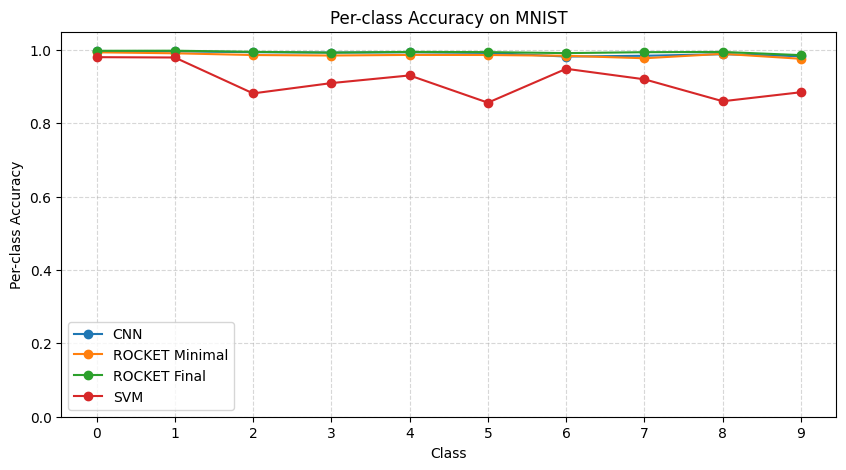

Saved plot as per_class_accuracy_cifar-10.pdf


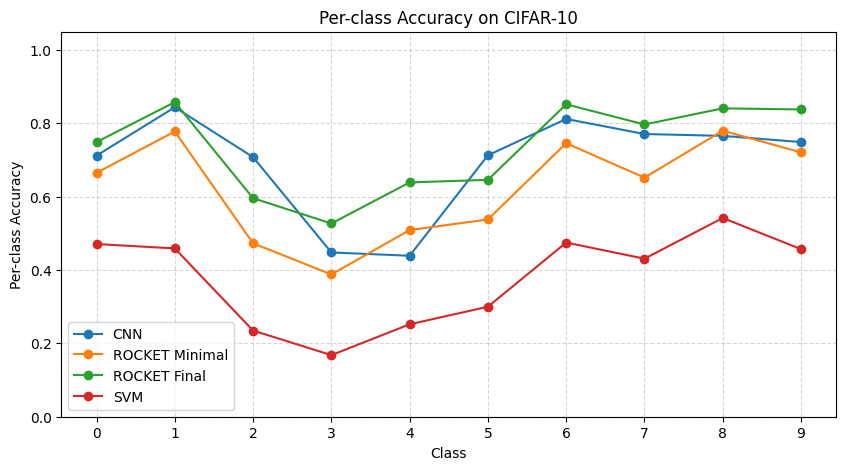

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# classes 0-9
classes = np.arange(10)

# Per-class accuracy Data
accuracy_data = {
    "MNIST": {
        "CNN": {
            "per_class": [0.9969, 0.9965, 0.9942, 0.9931, 0.9939, 0.9922, 0.9823, 0.9844, 0.9887, 0.9832]
        },
        "ROCKET Minimal": {
            # Pure ROCKET 1D (bestes alpha aus Pure ROCKET 1D run: alpha=1000)
            "per_class": [0.9938775510204082, 0.9911894273127754, 0.9864341085271318, 0.9851485148514851,
                          0.9867617107942973, 0.9865470852017937, 0.9843423799582464, 0.9776264591439688,
                          0.9897330595482546, 0.9762140733399405]
        },
        "ROCKET Final": {
            # Final pipeline (bestes alpha aus Final run: alpha=1200)
            "per_class": [0.9979591836734694, 0.9982378854625551, 0.9951550387596899, 0.9930693069306931,
                          0.994908350305499, 0.9943946188340808, 0.9916492693110647, 0.9941634241245136,
                          0.9948665297741273, 0.9861248761149654]
        },
        "SVM": {
            "per_class": [0.9806, 0.9797, 0.8818, 0.9099, 0.9308, 0.8565, 0.9489, 0.9202, 0.8604, 0.885]
        }
    },
    "CIFAR-10": {
        "CNN": {
            "per_class": [0.7120, 0.8440, 0.7080, 0.4480, 0.4390, 0.7130, 0.8120, 0.7710, 0.7660, 0.7490]
        },
        "ROCKET Minimal": {
            # Pure ROCKET 1D (bestes alpha aus Pure ROCKET 1D run: alpha=1000)
            "per_class": [0.665, 0.778, 0.473, 0.388, 0.509, 0.538, 0.746, 0.652, 0.78, 0.721]
        },
        "ROCKET Final": {
            # Final pipeline (bestes alpha aus Final run: alpha=2400)
            "per_class": [0.749, 0.858, 0.596, 0.527, 0.639, 0.646, 0.852, 0.797, 0.841, 0.838]
        },
        "SVM": {
            "per_class": [0.471, 0.459, 0.235, 0.168, 0.252, 0.300, 0.475, 0.431, 0.542, 0.457]
        }
    }
}


def plot_per_class_accuracy(dataset, save_pdf=True):
    plt.figure(figsize=(10,5))
    for model, acc in accuracy_data[dataset].items():
        plt.plot(classes, acc["per_class"], marker='o', label=model)
    plt.xticks(classes)
    plt.xlabel("Class")
    plt.ylabel("Per-class Accuracy")
    plt.ylim(0,1.05)
    plt.title(f"Per-class Accuracy on {dataset}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    if save_pdf:
        pdf_name = f"per_class_accuracy_{dataset.replace(' ','_').lower()}.pdf"
        plt.savefig(pdf_name, bbox_inches='tight')
        print(f"Saved plot as {pdf_name}")

    plt.show()

# MNIST plot
plot_per_class_accuracy("MNIST")

# CIFAR-10 plot
plot_per_class_accuracy("CIFAR-10")

# KTH-TIPS Tests

First exploration on SVM and CNN Baselines, as well as run on final 2D Rocket Pipeline on KTH-TIPS. KTH TIPS represents a small structured image dataset.

In [ ]:
import tarfile

tar_path = "/content/kth_tips_grey_200x200.tar"
with tarfile.open(tar_path, "r") as tar:
    tar.extractall("/content")

/tmp/ipython-input-813561799.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("/content")


In [ ]:
# Create deterministic train/test split
# Result: content/KTH_TIPS/train/<class>/*  and content/KTH_TIPS/test/<class>/*

import os, random, shutil
from pathlib import Path

ROOT = "KTH_TIPS"
TRAIN_RATIO = 0.8           # 80% train / 20% test
SEED = 42                   # deterministic split
COPY_INSTEAD_OF_MOVE = True # True = copy, False = move

random.seed(SEED)

def make_splits(root_dir: str, train_ratio: float = 0.8, seed: int = 42, copy=True):
    root = Path(root_dir)
    assert root.exists(), f"{root} nicht gefunden"
    classes = [p for p in root.iterdir() if p.is_dir()]
    if not classes:
        raise RuntimeError(f"Keine Klassenordner in {root}. Erwartet content/KTH_TIPS/<class>/*")
    train_root = root.joinpath("train")
    test_root = root.joinpath("test")
    train_root.mkdir(parents=True, exist_ok=True)
    test_root.mkdir(parents=True, exist_ok=True)

    for cls in classes:
        if cls.name in ("train", "test"):
            continue
        cls_files = [p for p in cls.glob("*") if p.is_file()]
        cls_files.sort()
        random.Random(seed).shuffle(cls_files)
        n_train = int(len(cls_files) * train_ratio)
        train_files = cls_files[:n_train]
        test_files = cls_files[n_train:]

        dest_train_cls = train_root.joinpath(cls.name)
        dest_test_cls = test_root.joinpath(cls.name)
        dest_train_cls.mkdir(parents=True, exist_ok=True)
        dest_test_cls.mkdir(parents=True, exist_ok=True)

        for p in train_files:
            if copy:
                shutil.copy2(p, dest_train_cls.joinpath(p.name))
            else:
                shutil.move(p, dest_train_cls.joinpath(p.name))
        for p in test_files:
            if copy:
                shutil.copy2(p, dest_test_cls.joinpath(p.name))
            else:
                shutil.move(p, dest_test_cls.joinpath(p.name))
        print(f"Klasse {cls.name}: {len(train_files)} train / {len(test_files)} test")

    print(f"Done. Train dir: {train_root} | Test dir: {test_root}")

make_splits(ROOT, train_ratio=TRAIN_RATIO, seed=SEED, copy=COPY_INSTEAD_OF_MOVE)

Klasse brown_bread: 64 train / 17 test
Klasse styrofoam: 64 train / 17 test
Klasse aluminium_foil: 64 train / 17 test
Klasse cotton: 64 train / 17 test
Klasse orange_peel: 64 train / 17 test
Klasse sandpaper: 64 train / 17 test
Klasse corduroy: 64 train / 17 test
Klasse linen: 64 train / 17 test
Klasse sponge: 64 train / 17 test
Klasse cracker: 64 train / 17 test
Done. Train dir: KTH_TIPS/train | Test dir: KTH_TIPS/test


Calculate Mean and Std for KTH-TIPS

In [ ]:
# Calculate mean/std for kthtips (Grayscale -> 1 channel), images scaled to 32x32.
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import math

root = "KTH_TIPS"
which_split = "train"
dataset_dir = os.path.join(root, which_split)

if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"{dataset_dir} nicht gefunden. Erwartet: {root}/train und {root}/test oder passe path an.")

# Transform: Resize -> Grayscale(1) -> ToTensor (range [0,1])
tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

ds = datasets.ImageFolder(dataset_dir, transform=tf)
loader = DataLoader(ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

# mean/std (per-channel)
n_pixels = 0
sum_ = 0.0
sumsq = 0.0
device = "cpu"

for xb, _ in loader:
    xb = xb.to(device)          # shape (B,1,H,W)
    B, C, H, W = xb.shape
    nb = B * H * W
    # Sum per all pixels (channel dims preserved)
    sum_ += xb.sum().item()
    sumsq += (xb * xb).sum().item()
    n_pixels += nb

mean = sum_ / n_pixels
var = (sumsq / n_pixels) - (mean * mean)
std = math.sqrt(max(var, 1e-12))

print(f"kthtips ({which_split}) mean: {mean:.6f}, std: {std:.6f}")

kthtips (train) mean: 0.490255, std: 0.114054


Data Loader for KTH-TIPS

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import config

DATA_ROOT = os.environ.get("THREE_DATA_ROOT", "KTH_TIPS")

# Standard transform: Resize -> Grayscale -> ToTensor -> dataset-normalize
# take calculated mean and std
tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(0.490255, 0.114054),
])

train_root = os.path.join(DATA_ROOT, "train")
test_root  = os.path.join(DATA_ROOT, "test")

if not os.path.isdir(train_root) or not os.path.isdir(test_root):
    raise FileNotFoundError(f"Erwarte train/ und test/-Ordner unter {DATA_ROOT}. Gefunden: {os.listdir(DATA_ROOT) if os.path.isdir(DATA_ROOT) else 'keine ordner'}")

train_ds = datasets.ImageFolder(train_root, transform=tf)
test_ds  = datasets.ImageFolder(test_root,  transform=tf)

# loader params from config.py
batch_cfg = config.get_batch_config()
train_loader = DataLoader(train_ds, batch_size=batch_cfg["batch_size_train"], shuffle=True,
                          num_workers=batch_cfg["num_workers"], pin_memory=batch_cfg["pin_memory"],
                          generator=None)
test_loader  = DataLoader(test_ds,  batch_size=batch_cfg["batch_size_test"], shuffle=False,
                          num_workers=batch_cfg["num_workers"], pin_memory=batch_cfg["pin_memory"])

in_channels = 1
image_hw = (32, 32)
seq_len = image_hw[0] * image_hw[1]

print(f"Loaded dataset from {DATA_ROOT}: classes={train_ds.classes}, train={len(train_ds)}, test={len(test_ds)}")
print("Batch config:", batch_cfg)

Loaded dataset from KTH_TIPS: classes=['aluminium_foil', 'brown_bread', 'corduroy', 'cotton', 'cracker', 'linen', 'orange_peel', 'sandpaper', 'sponge', 'styrofoam'], train=640, test=170
Batch config: {'batch_size_train': 512, 'batch_size_test': 512, 'num_workers': 2, 'pin_memory': True}


SVM Baseline on KTH-TIPS

In [ ]:
import os, time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import confusion_matrix
import csv
import pandas as pd

import config
config.set_seed(config.SEED)
config.set_deterministic()

# SVM params
C_grid = [0.1]
rp_dim = 1024 * 2  # set None to disable projection
max_iter = 1000

# Use loaders from previous cells
train_loader = globals().get("train_loader", None)
test_loader  = globals().get("test_loader", None)
if train_loader is None or test_loader is None:
    raise RuntimeError("train_loader/test_loader nicht gefunden. Bitte zuerst die DataLoader-Zelle ausführen.")

def loader_to_numpy(loader, flatten=True):
    xs, ys = [], []
    for xb, yb in loader:
        x = xb.numpy()
        if flatten:
            x = x.reshape(x.shape[0], -1)
        xs.append(x); ys.append(yb.numpy())
    return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)

X_tr, y_tr = loader_to_numpy(train_loader, flatten=True)
X_te, y_te = loader_to_numpy(test_loader,  flatten=True)

scaler = StandardScaler().fit(X_tr)
Xtr_s = scaler.transform(X_tr); Xte_s = scaler.transform(X_te)

if rp_dim is not None:
    # Guard: don't request more components than features
    rp = GaussianRandomProjection(n_components=min(rp_dim, Xtr_s.shape[1]), random_state=config.SEED)
    Xtr_s = rp.fit_transform(Xtr_s); Xte_s = rp.transform(Xte_s)

best = {"acc": -1}
results = []
for C in C_grid:
    t_start = time.time()
    clf = LinearSVC(C=C, max_iter=max_iter, random_state=config.SEED)
    clf.fit(Xtr_s, y_tr)
    train_time_C = time.time() - t_start
    y_pred = clf.predict(Xte_s)
    acc = float((y_pred == y_te).mean())
    conf = confusion_matrix(y_te, y_pred)
    per_class_acc = (conf.diagonal() / conf.sum(axis=1)).tolist()
    print(f"[custom_three][SVM-raw+RP] C={C} | acc={acc:.4f} | train_time={train_time_C:.2f}s")
    print(f"Per-class accuracy: {np.round(per_class_acc,4)}")
    results.append({"dataset":"custom_three","classifier":"linear_svm_rp","C":C,"acc":acc,"train_time":train_time_C,"feature_dim":Xtr_s.shape[1],"per_class_acc":per_class_acc})
    if acc > best["acc"]:
        best.update({"acc": acc, "C": C, "ypred": y_pred, "train_time": train_time_C, "per_class_acc": per_class_acc})

csv_name = f"./svm_baseline_results_custom_three.csv"
pd.DataFrame(results).to_csv(csv_name, index=False)
print("Best SVM result saved to", csv_name)
print("Summary: ", best)

[custom_three][SVM-raw+RP] C=0.1 | acc=0.3941 | train_time=7.63s
Per-class accuracy: [0.     0.4706 0.7059 0.4118 0.4118 0.4706 0.2941 0.2941 0.4706 0.4118]
Best SVM result saved to ./svm_baseline_results_custom_three.csv
Summary:  {'acc': 0.3941176470588235, 'C': 0.1, 'ypred': array([2, 7, 9, 9, 9, 1, 9, 1, 3, 7, 3, 2, 9, 6, 7, 9, 5, 8, 9, 1, 9, 5,
       5, 1, 1, 3, 8, 9, 1, 1, 1, 1, 1, 8, 2, 9, 9, 2, 3, 9, 2, 2, 2, 2,
       9, 2, 2, 2, 2, 2, 2, 7, 2, 7, 7, 7, 3, 3, 3, 5, 9, 7, 3, 9, 7, 3,
       3, 3, 8, 3, 3, 4, 9, 1, 7, 7, 7, 6, 8, 4, 4, 4, 4, 4, 4, 9, 9, 5,
       3, 9, 3, 5, 8, 3, 9, 7, 5, 5, 5, 5, 5, 5, 7, 7, 8, 7, 7, 3, 7, 5,
       3, 3, 6, 5, 6, 6, 6, 6, 5, 2, 3, 8, 3, 7, 9, 7, 7, 7, 7, 9, 5, 3,
       3, 3, 3, 3, 7, 3, 5, 8, 8, 8, 5, 7, 5, 3, 2, 8, 8, 8, 8, 3, 8, 7,
       7, 5, 8, 7, 3, 9, 9, 9, 2, 7, 7, 7, 9, 9, 9, 9]), 'train_time': 7.632181167602539, 'per_class_acc': [0.0, 0.47058823529411764, 0.7058823529411765, 0.4117647058823529, 0.4117647058823529, 0.47058823529411

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CNN Baseline on KTH-TIPS

In [ ]:
import time, os
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import pandas as pd

import config
from utils.eval import evaluate_and_report

# reproducibility
config.set_seed(config.SEED)
config.set_deterministic()

device = config.DEVICE
batch_cfg = config.get_batch_config()
print("Using batch config:", batch_cfg)
print("Using stride config:", config.get_stride_config())

# SmallCNN
class SmallCNN(nn.Module):
    def __init__(self, in_channels: int, img_size: int, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            # get number of classes from the dataset; assume train loader exists
            ds = globals().get("train_loader").dataset if globals().get("train_loader") is not None else None
            num_classes = len(ds.classes) if ds is not None else 10
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        feat = img_size // 4
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*feat*feat, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x): return self.classifier(self.features(x))

# prepare loaders: assume train_loader/test_loader from loader cell exist
train_loader = globals().get("train_loader", None)
test_loader  = globals().get("test_loader", None)
if train_loader is None or test_loader is None:
    raise RuntimeError("train_loader/test_loader nicht gefunden. Bitte zuerst die DataLoader-Zelle ausführen.")

in_channels = globals().get("in_channels", 1)
img_sz = globals().get("image_hw", (32,32))[0]
num_classes = len(train_loader.dataset.classes)

epochs = int(os.environ.get("EPOCHS", "10"))

model = SmallCNN(in_channels, img_sz, num_classes=num_classes).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def eval_loader(model, loader, device):
    model.eval()
    correct, total = 0, 0
    logits_list, y_list = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        logits_list.append(logits.detach().cpu().numpy()); y_list.append(yb.detach().cpu().numpy())
    logits = np.concatenate(logits_list, axis=0) if logits_list else np.zeros((0,num_classes))
    y_true = np.concatenate(y_list, axis=0) if y_list else np.zeros((0,), dtype=int)
    y_pred = logits.argmax(axis=1) if logits_list else np.zeros((0,), dtype=int)
    return (correct/total if total>0 else 0.0), y_true, y_pred, logits

t0_all = time.time()
for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
    acc_val, _, _, _ = eval_loader(model, test_loader, device)
    print(f"[cnn_small_custom] epoch {ep:02d} | test acc {acc_val:.4f}")

train_time = time.time() - t0_all
acc, y_true, y_pred, logits = eval_loader(model, test_loader, device)
evaluate_and_report("cnn_small_custom", "custom_three", config.SEED, y_true, y_pred, scores=logits, train_time=train_time)

# save simple results CSV
CACHE_DIR = os.path.join(os.environ.get("CACHE_DIR", "/content"), "cnn_custom_cache")
os.makedirs(CACHE_DIR, exist_ok=True)
RESULTS_CSV = os.path.join(CACHE_DIR, "cnn_results_custom.csv")
pd.DataFrame([{"dataset":"custom_three","model":"cnn_small","seed":config.SEED,"accuracy":acc,"train_time":train_time}]).to_csv(RESULTS_CSV, index=False)
print("CNN results saved to:", RESULTS_CSV)

Using batch config: {'batch_size_train': 512, 'batch_size_test': 512, 'num_workers': 2, 'pin_memory': True}
Using stride config: {'stride_1d': 1, 'stride_2d': 1}
[cnn_small_custom] epoch 01 | test acc 0.1471
[cnn_small_custom] epoch 02 | test acc 0.2059
[cnn_small_custom] epoch 03 | test acc 0.2294
[cnn_small_custom] epoch 04 | test acc 0.3059
[cnn_small_custom] epoch 05 | test acc 0.3471
[cnn_small_custom] epoch 06 | test acc 0.4059
[cnn_small_custom] epoch 07 | test acc 0.4176
[cnn_small_custom] epoch 08 | test acc 0.4412
[cnn_small_custom] epoch 09 | test acc 0.4353
[cnn_small_custom] epoch 10 | test acc 0.4588
[cnn_small_custom][custom_three][seed=42] acc=0.4588 | train_time=11.97427487373352s
              precision    recall  f1-score   support

           0     1.0000    0.4118    0.5833        17
           1     0.6923    0.5294    0.6000        17
           2     0.5000    0.5882    0.5405        17
           3     0.0000    0.0000    0.0000        17
           4     0.481

Final ROCKET Pipeline on KTH-TIPS

In [ ]:
# final ROCKET pipeline for den kth-tips grayscale-32x32 dataset
# takes same settings as final ROCKET pipeline

import time, os
import pandas as pd
from pathlib import Path

import config
from utils.kernels import make_random_kernels_2d, count_kernels, kernel_hash
from utils.features import extract_features_2d
from utils.eval import per_class_accuracy
from utils.sanity import estimate_feature_bytes
from utils.settings import get_cache_dir
from utils.constants import FEATURE_TYPES_2D as FEATURE_TYPES, PREPROC_IMAGE_NORM

# reproducibility
config.set_seed(config.SEED)
config.set_deterministic()

# experiment level defaults
N_KERNELS_FINAL = int(os.environ.get("N_KERNELS_FINAL", "5000"))
BEST_CONFIGS = {
    # fallback
    "default": {"name":"mixed_moderate","k_choices":[3,5,7,9],"d_choices":[1,2],"description":"mixed moderate"}
}
cfg = BEST_CONFIGS["default"]

# Cache / results
CACHE_DIR = get_cache_dir("rocket_final_custom_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_CSV = str(Path(CACHE_DIR).joinpath("final_kernel_results_customdataset.csv"))

try:
    train_loader, test_loader, in_channels_var, image_hw_var, seq_len_var
    # If objects not defined, the above will raise NameError; but we don't want to crash here:
except Exception:
    # If the variables aren't in globals, try to import or expect user to run data loader cell
    pass

# Use the train_loader/test_loader variables created by the loader cell:
# If those names are not bound in this cell's scope, assume user ran the loader cell which defined them globally.
train_loader = globals().get("train_loader", None)
test_loader = globals().get("test_loader", None)
in_channels = globals().get("in_channels", 1)
image_hw = globals().get("image_hw", (32,32))
seq_len = globals().get("seq_len", 32*32)

if train_loader is None or test_loader is None:
    raise RuntimeError("train_loader/test_loader nicht gefunden. Bitte vorher die DataLoader-Zelle ausführen.")

print(f"Running ROCKET final on custom dataset: N_KERNELS={N_KERNELS_FINAL}, config={cfg['name']}, in_channels={in_channels}, image_hw={image_hw}")

kernels = make_random_kernels_2d(
    N_KERNELS_FINAL, in_channels,
    cfg["k_choices"], cfg["d_choices"],
    seed=config.SEED
)

kh = kernel_hash(kernels)
cnt = count_kernels(kernels)
print("kernel hash:", kh, "count:", cnt)

# Features extraction (valid padding)
X_train, y_train = extract_features_2d(
    train_loader, kernels, FEATURE_TYPES,
    image_hw=image_hw,
    padding_mode="valid",
    stride=config.STRIDE_2D,
    seed=config.SEED
)

X_test, y_test = extract_features_2d(
    test_loader, kernels, FEATURE_TYPES,
    image_hw=image_hw,
    padding_mode="valid",
    stride=config.STRIDE_2D,
    seed=config.SEED
)

print(f"Features: train={X_train.shape} test={X_test.shape}")

if X_train.shape[1] == 0:
    print("No features -> skip")
else:
    print("Estimated feature size (GiB):", estimate_feature_bytes(len(train_loader.dataset), X_train.shape[1]) / (1024**3))

from config import build_ridge
from sklearn.metrics import accuracy_score

results = []
for alpha in config.ALPHAS:
    pipe = build_ridge(alpha=alpha, scale=True)
    t0 = time.time()
    pipe.fit(X_train, y_train)
    tt = time.time() - t0
    ypred = pipe.predict(X_test)
    acc = accuracy_score(y_test, ypred)
    per_class_acc = per_class_accuracy(y_test, ypred)
    print(f"[custom_dataset] ridge alpha={alpha} acc={acc:.4f} time={tt:.1f}s")
    print("Per-class acc:", per_class_acc)
    results.append({
        "dataset": "custom_three",
        "classifier": "ridge",
        "alpha": alpha,
        "acc": acc,
        "train_time": tt,
        "feature_dim": X_train.shape[1],
        "n_kernels": N_KERNELS_FINAL,
        "per_class_acc": per_class_acc
    })

pd.DataFrame(results).to_csv(RESULTS_CSV, index=False)
print("Saved:", RESULTS_CSV)

Running ROCKET final on custom dataset: N_KERNELS=5000, config=mixed_moderate, in_channels=1, image_hw=(32, 32)
kernel hash: bce6afe94f6fc60da8617ccf777c3e5f count: 5000


Features: train=(640, 25000) test=(170, 25000)
Estimated feature size (GiB): 0.059604644775390625
[custom_dataset] ridge alpha=1000 acc=0.8471 time=0.4s
Per-class acc: {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0.7647058823529411, '4': 1.0, '5': 0.6470588235294118, '6': 0.8823529411764706, '7': 0.6470588235294118, '8': 0.9411764705882353, '9': 0.5882352941176471}
[custom_dataset] ridge alpha=1200 acc=0.8529 time=0.5s
Per-class acc: {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0.8235294117647058, '4': 1.0, '5': 0.6470588235294118, '6': 0.8823529411764706, '7': 0.6470588235294118, '8': 0.9411764705882353, '9': 0.5882352941176471}
[custom_dataset] ridge alpha=1400 acc=0.8529 time=0.5s
Per-class acc: {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0.8235294117647058, '4': 1.0, '5': 0.6470588235294118, '6': 0.8823529411764706, '7': 0.6470588235294118, '8': 0.9411764705882353, '9': 0.5882352941176471}
[custom_dataset] ridge alpha=1600 acc=0.8529 time=0.5s
Per-class acc: {'0': 1.0, '1': 1.0, '2': 1.0, '3': 0.82352941176